### What's Cooking Top 7% solution

The following is modified from the Kaggle competition "What's Cooking". Author is Anmol Tripathi. \
https://www.kaggle.com/code/anmoltripathi/what-s-cooking-top-7-solution

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import re
import nltk
import zipfile
import pickle

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
with open('train.json') as data_file:    
    data = json.load(data_file)
    
with open('test.json') as test_file:
    test = json.load(test_file)

In [8]:
df = pd.DataFrame(data)
test_df = pd.DataFrame(test)

test_ids = test_df['id']

df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [9]:
df.shape

(39774, 3)

In [10]:
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


### EDA

#### Missingness

In [11]:
(df.isnull().sum() / len(df))*100 # No null values in train

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [12]:
(test_df.isnull().sum() / len(test_df))*100 # No null values in test

id             0.0
ingredients    0.0
dtype: float64

#### Cuisine distribution

Very imbalanced. Majority is Italian dish, followed by Mexican, Souther United States, and Indian.

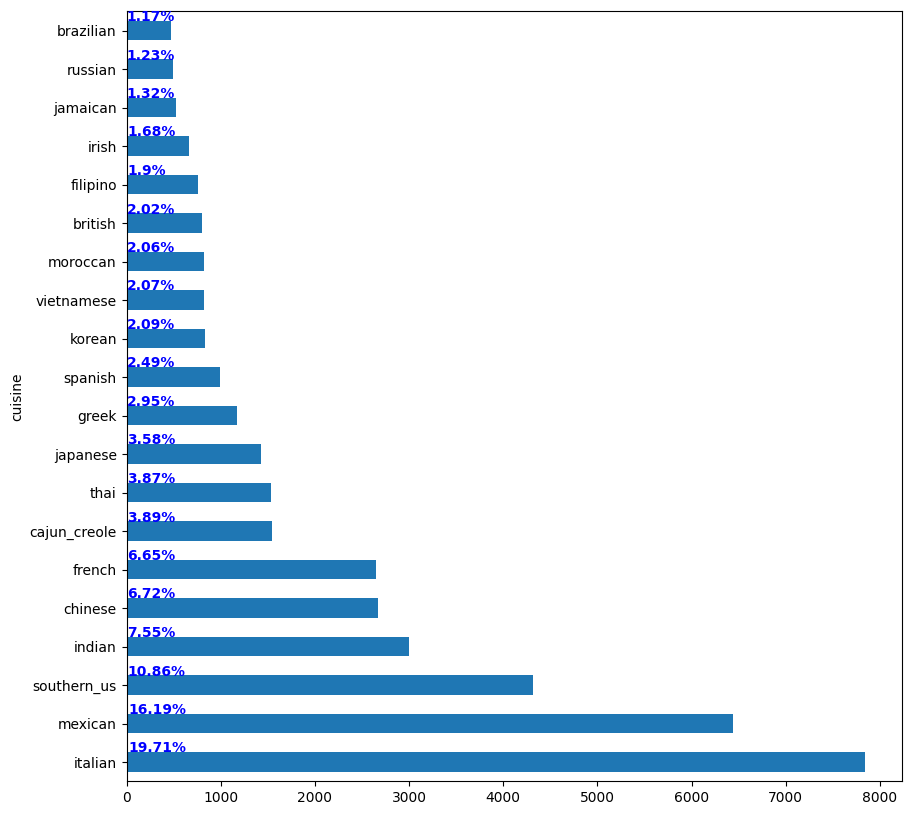

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
per_vals = round(df["cuisine"].value_counts(normalize=True)*100, 2)
for i, v in enumerate(per_vals):
    ax.text(v + 3, i + .25, str(v)+"%", color='blue', fontweight='bold')
df["cuisine"].value_counts().plot.barh(ax = ax)
plt.show()

#### Most common ingredients

Here we have the top 30 frequent ingredients here. Looks like they are mostly condiments.

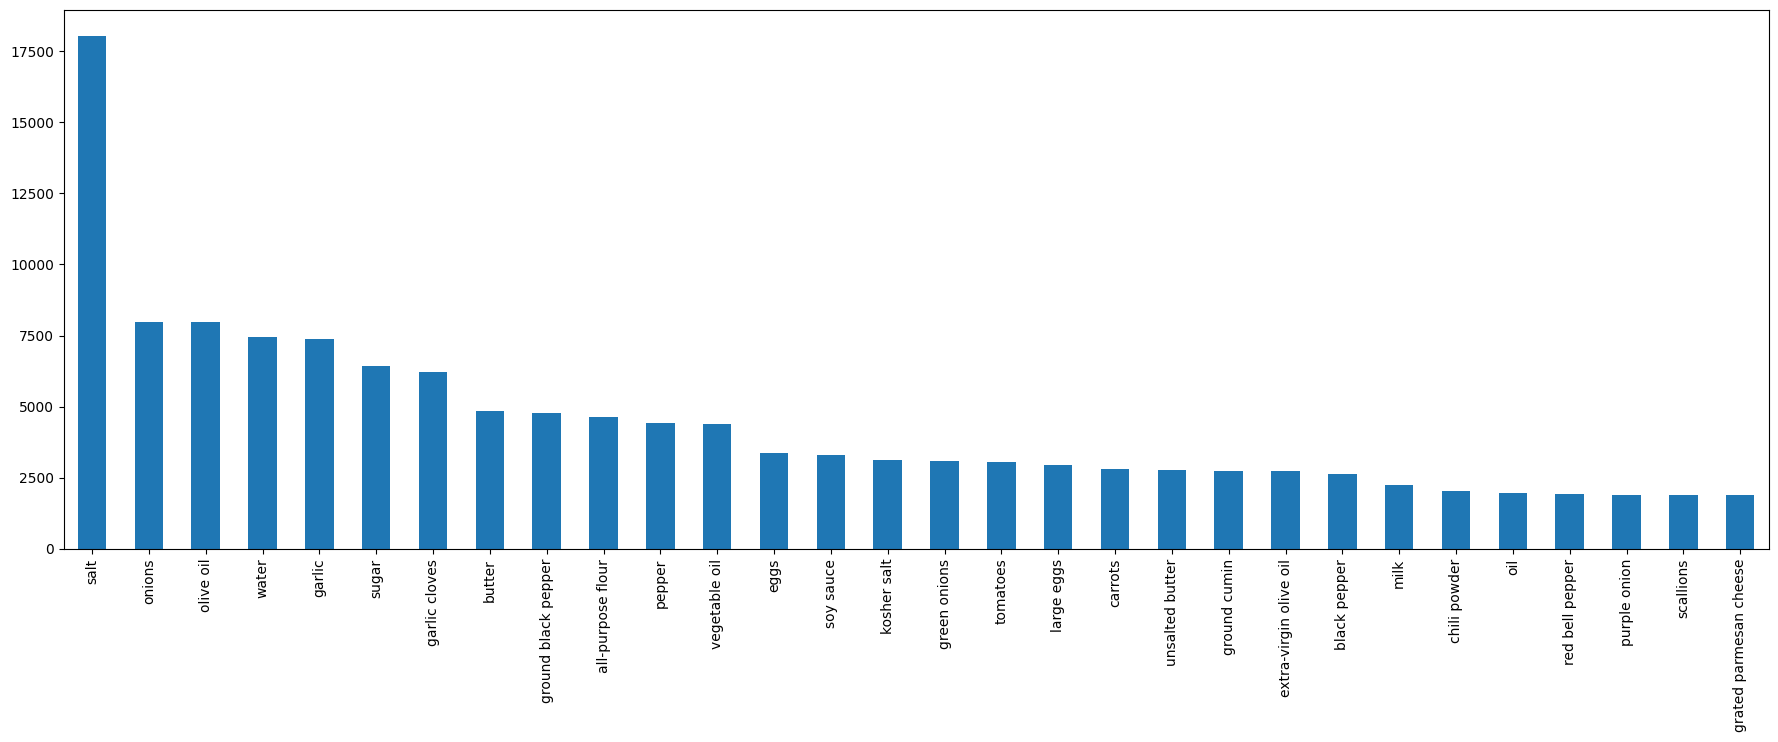

In [14]:
fig, ax = plt.subplots(figsize=(22,7))
extensive_ing_list = []
for x in df['ingredients']:
    for y in x:
        extensive_ing_list.append(y)
        
extensive_ing_list = pd.Series(extensive_ing_list)
extensive_ing_list.value_counts().sort_values(ascending=False).head(30).plot.bar(ax = ax)
plt.show()

#### Create ingredients per cuisine

In [15]:
cuisine = df["cuisine"].unique()

all_cus = dict()
for cs in cuisine:
    i = []
    for ing_list in df[df['cuisine']==cs]['ingredients']:
        for ing in ing_list:
            i.append(ing)
    all_cus[cs] = i

all_cus.keys()

dict_keys(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian'])

In [16]:
all_cus['greek']  # example

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles',
 'ground pork',
 'finely chopped fresh parsley',
 'onions',
 'salt',
 'vinegar',
 'caul fat',
 'minced garlic',
 'dried oregano',
 'red wine vinegar',
 'olive oil',
 'boneless chop pork',
 'lemon juice',
 'orange',
 'anise',
 'cinnamon sticks',
 'unflavored gelatin',
 'zinfandel',
 'orange blossom honey',
 'sugar',
 'lemon',
 'calimyrna figs',
 'clove',
 'honey',
 'whipping cream',
 'plain whole-milk yogurt',
 'fresh dill',
 'yoghurt',
 'salt',
 'myzithra',
 'large eggs',
 'cheese',
 'feta cheese',
 'phyllo',
 'kefalotyri',
 'ground black pepper',
 'extra-virgin olive oil',
 'onions',
 'olive oil',
 'salt',
 'hamburger buns',
 'paprika',
 'chopped fresh mint',
 'ground cinnamon',
 'balsamic vinegar',
 'feta cheese crumbles',
 'baby spinach leaves',
 'purple onion',
 'ground lamb',
 'pepper',
 'dried mint flakes',
 'salt',
 'dried orega

#### 25 Most used ingredients -- cuisine wise

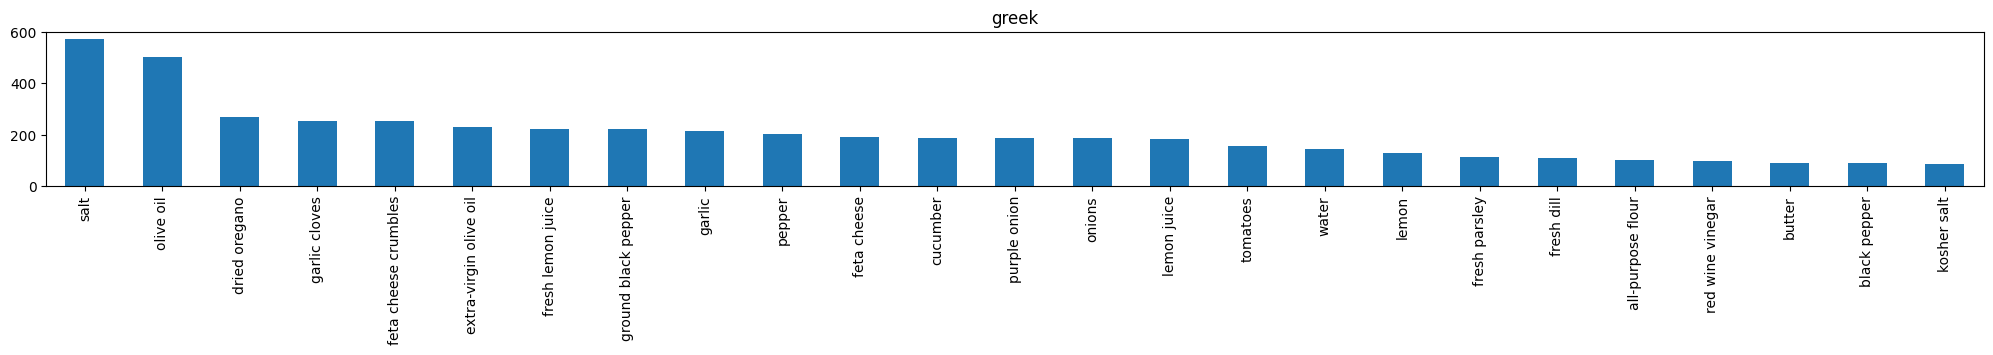

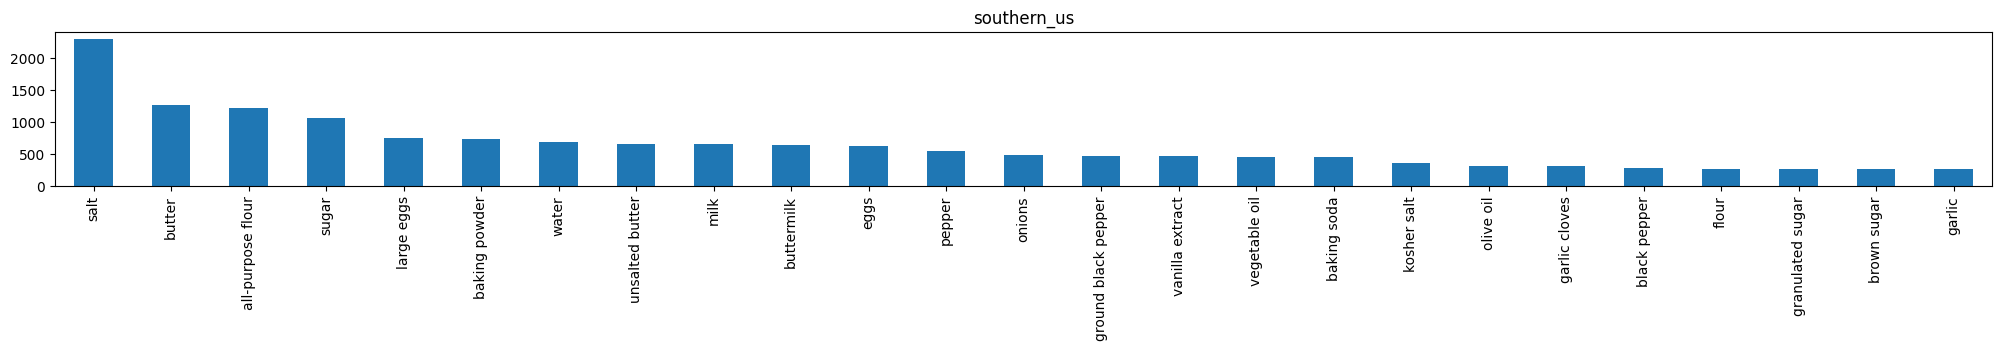

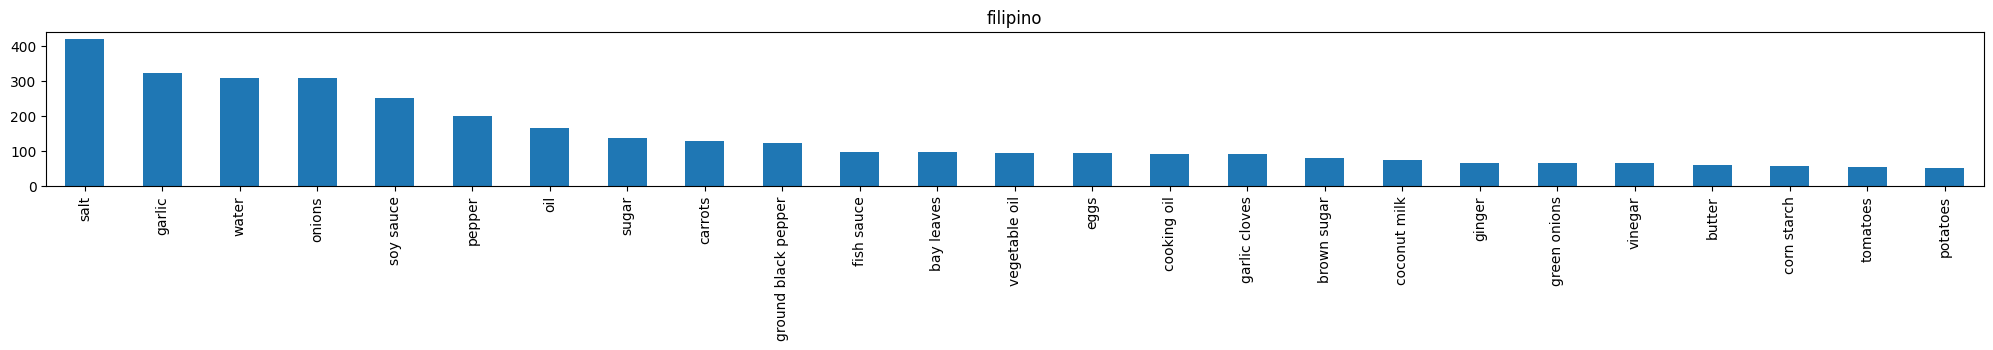

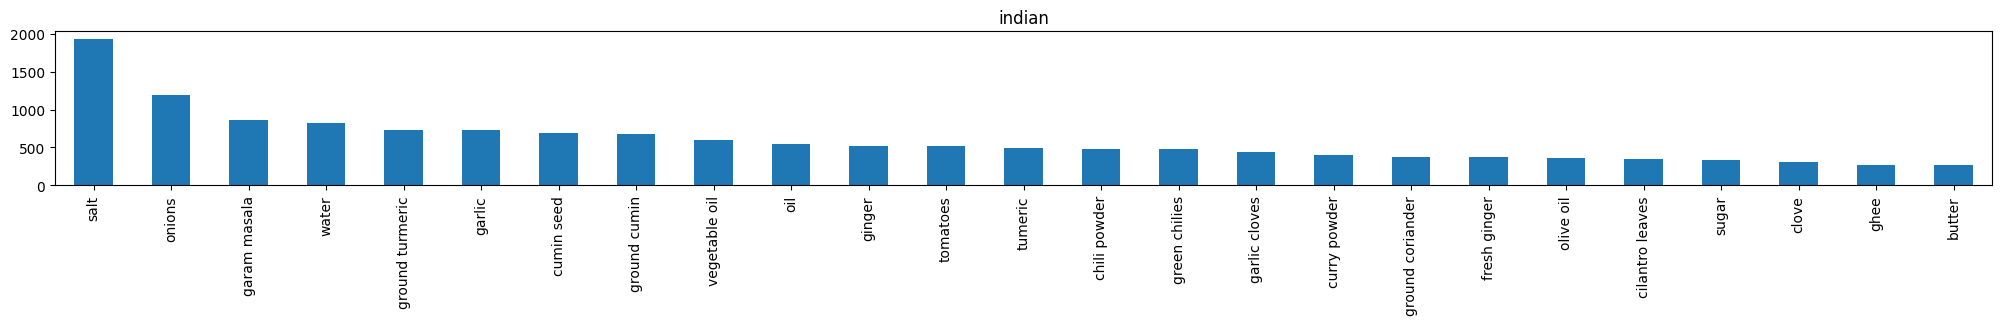

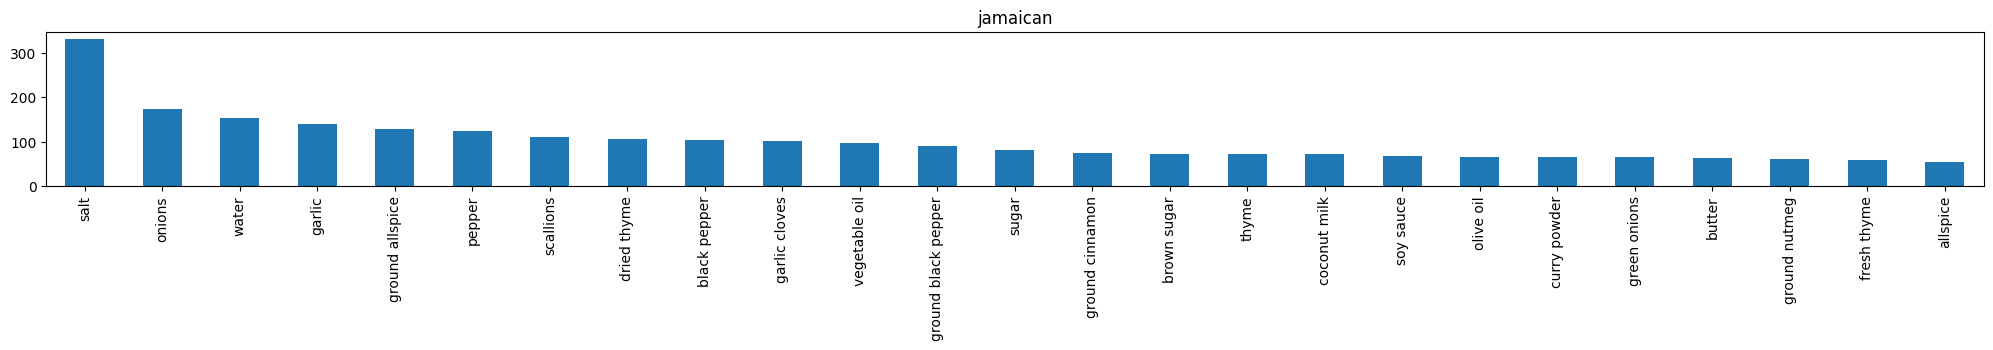

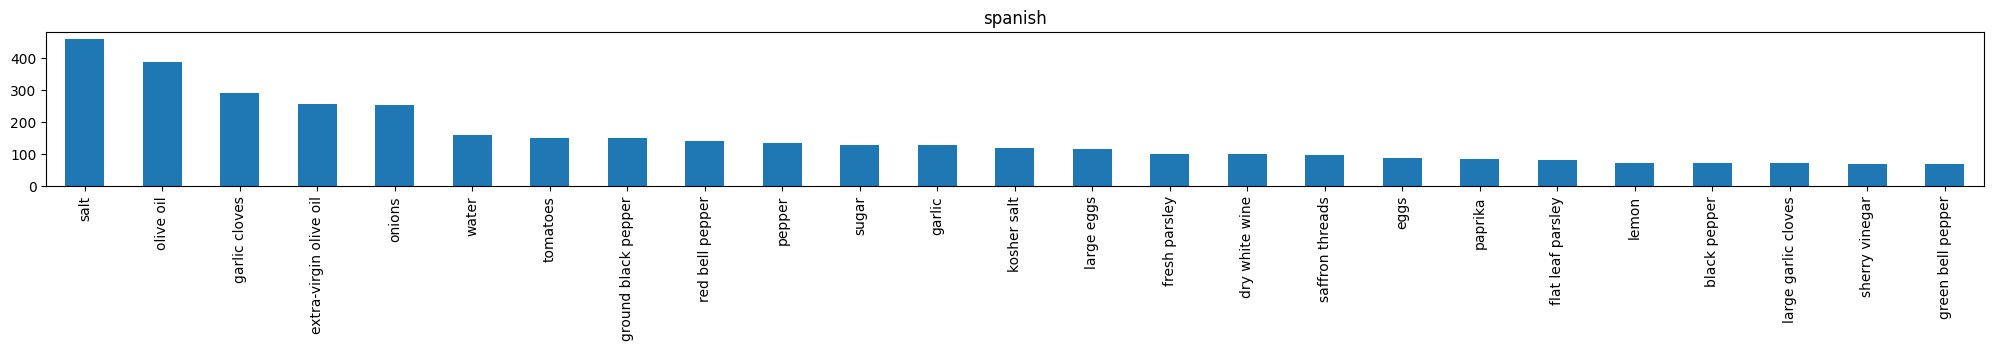

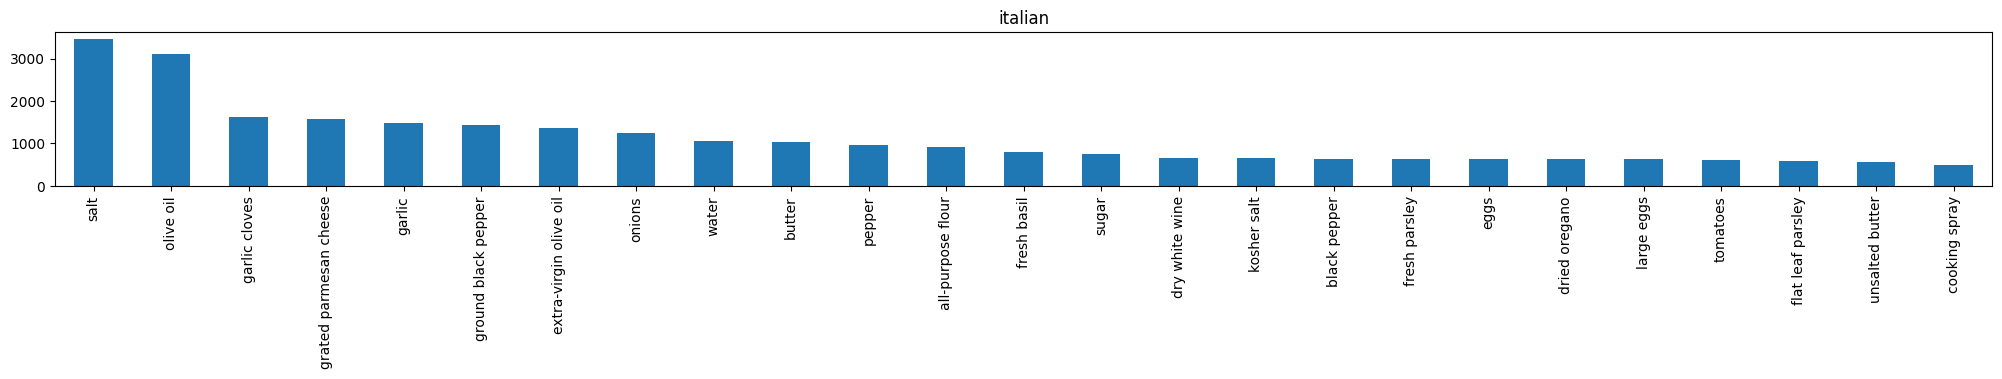

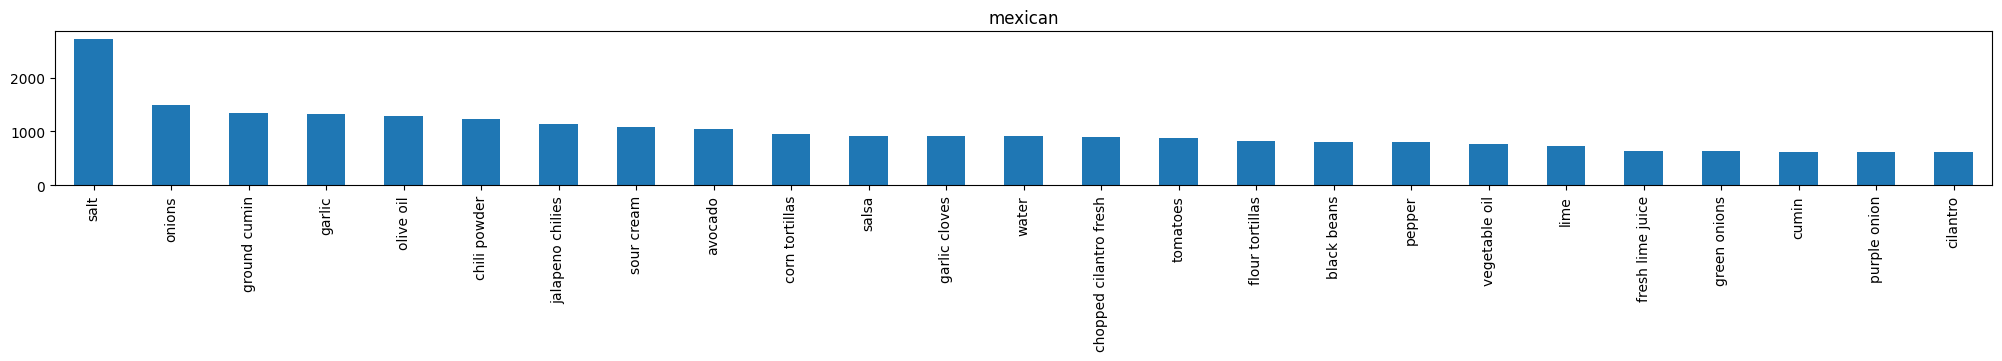

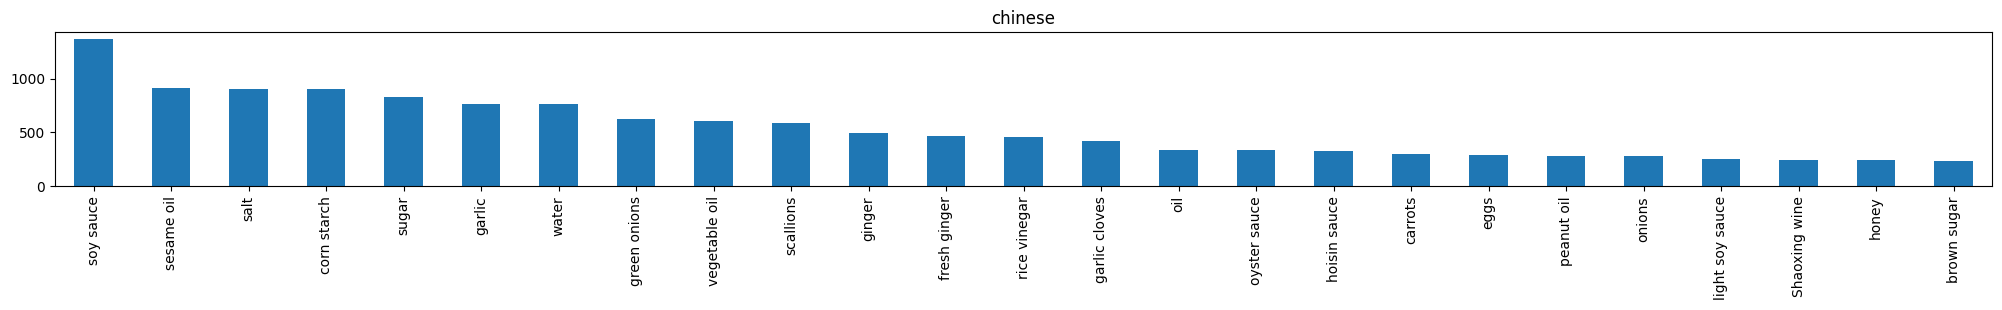

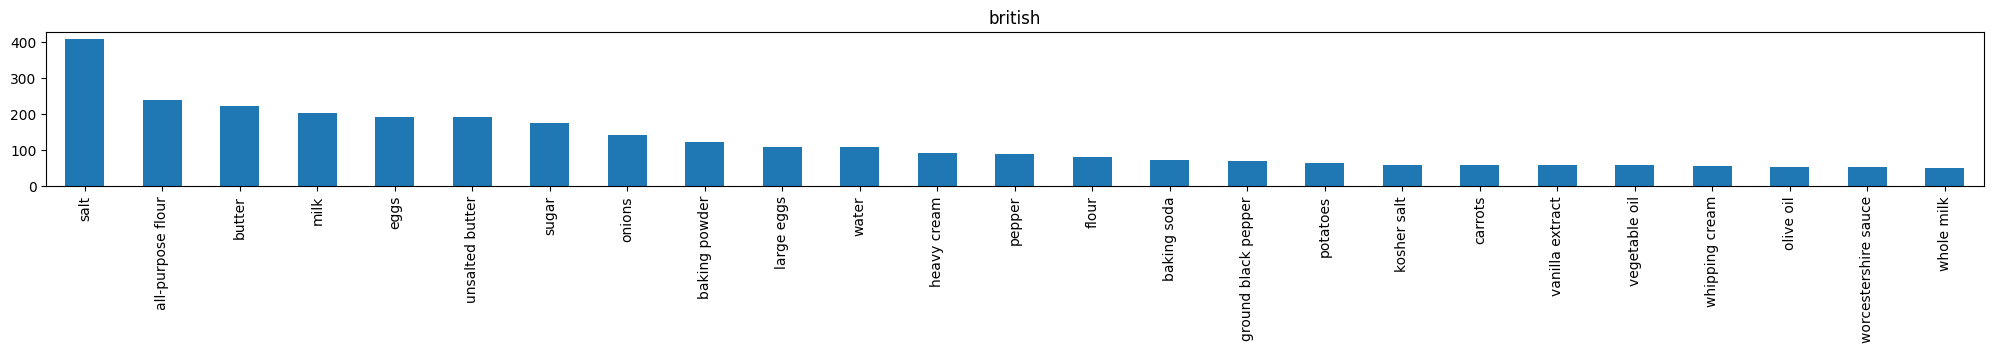

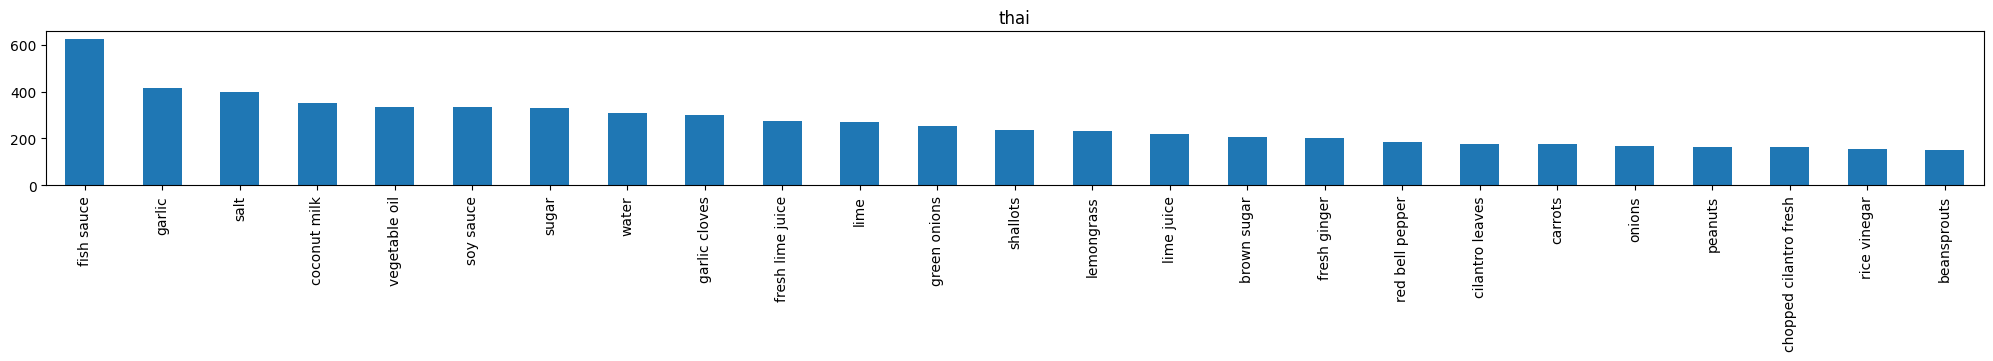

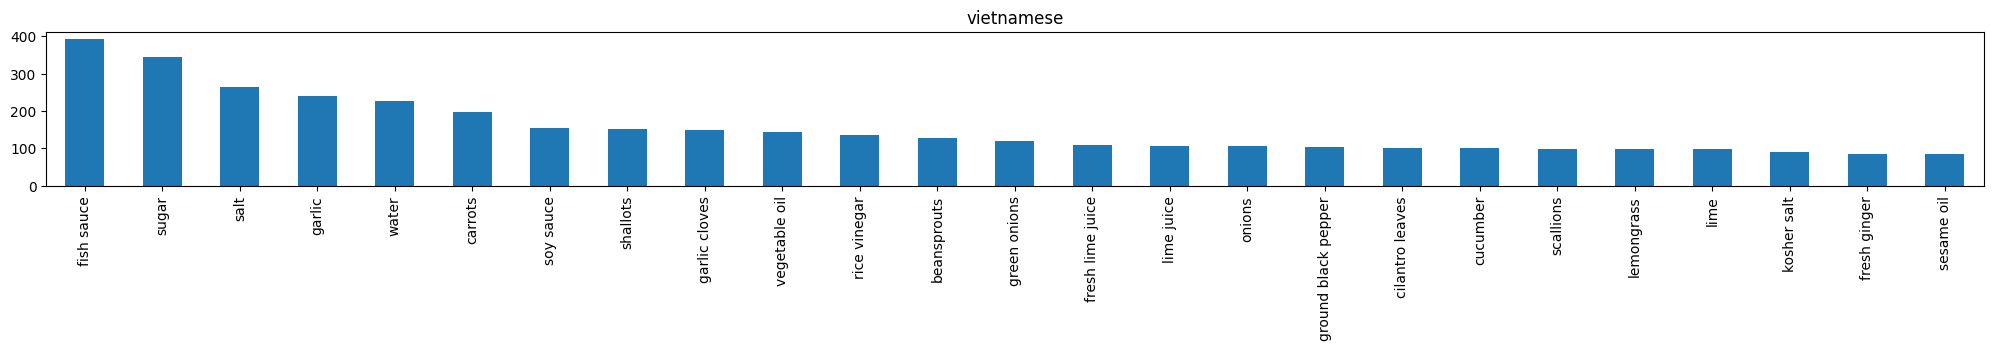

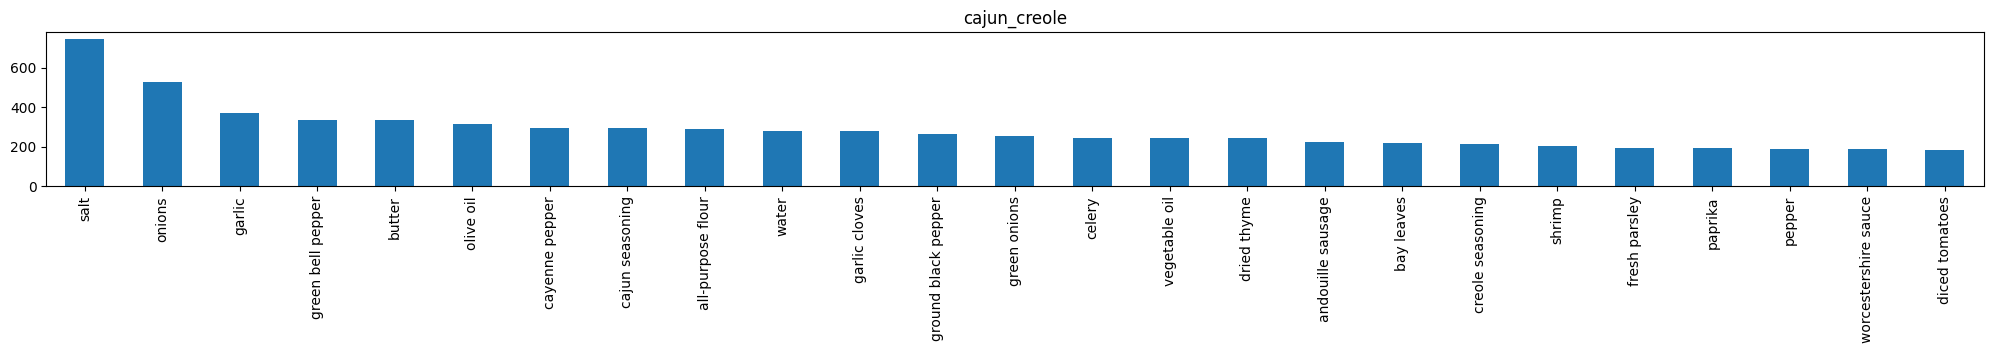

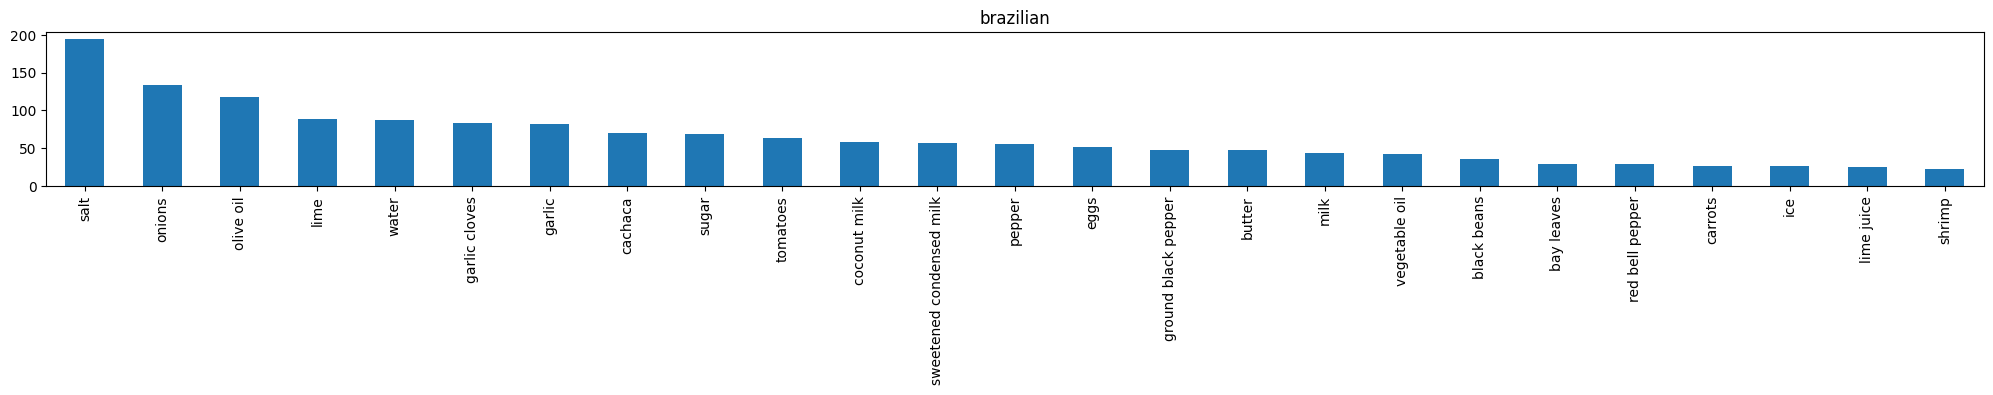

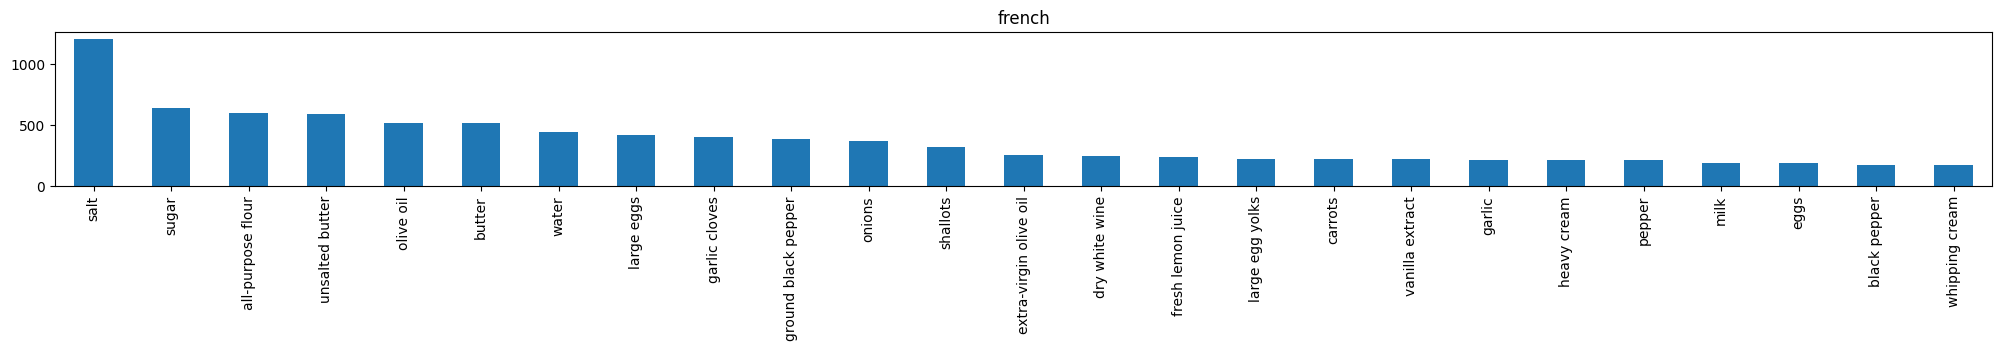

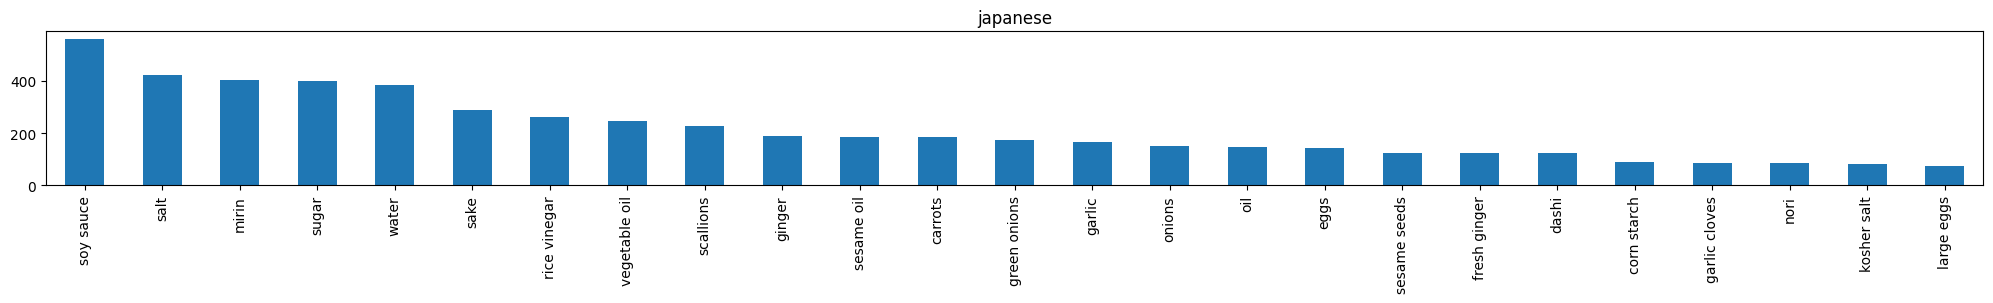

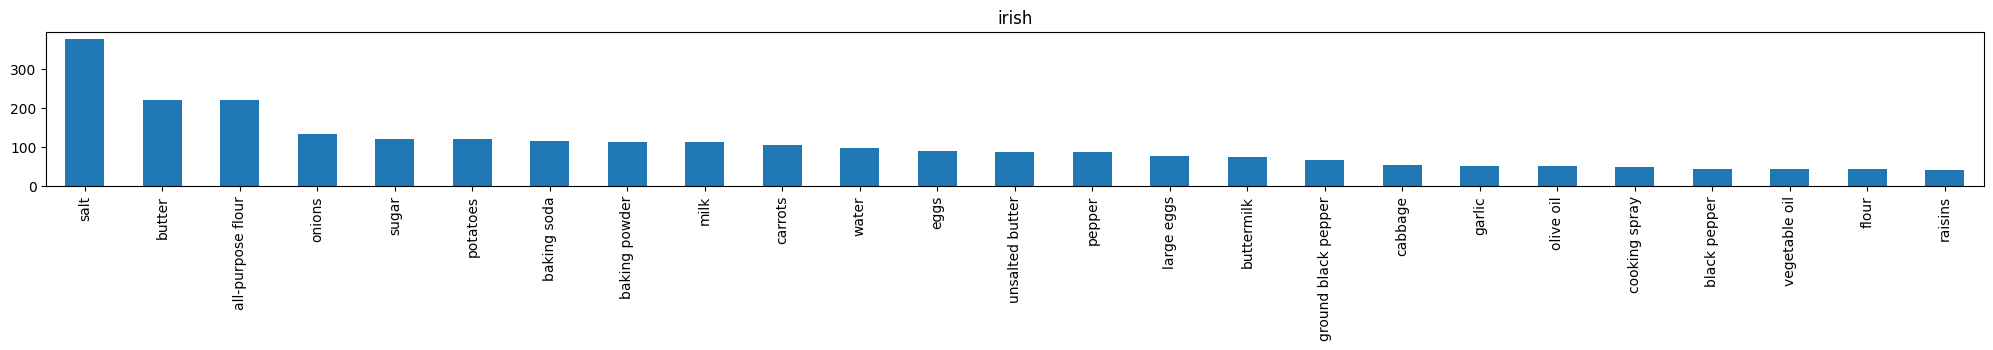

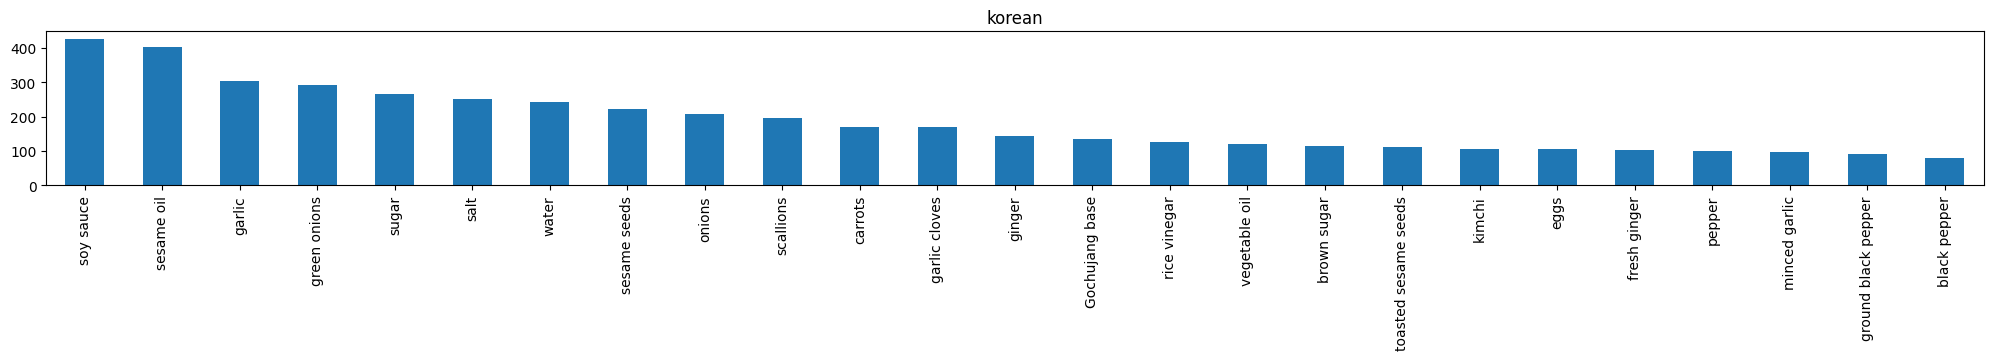

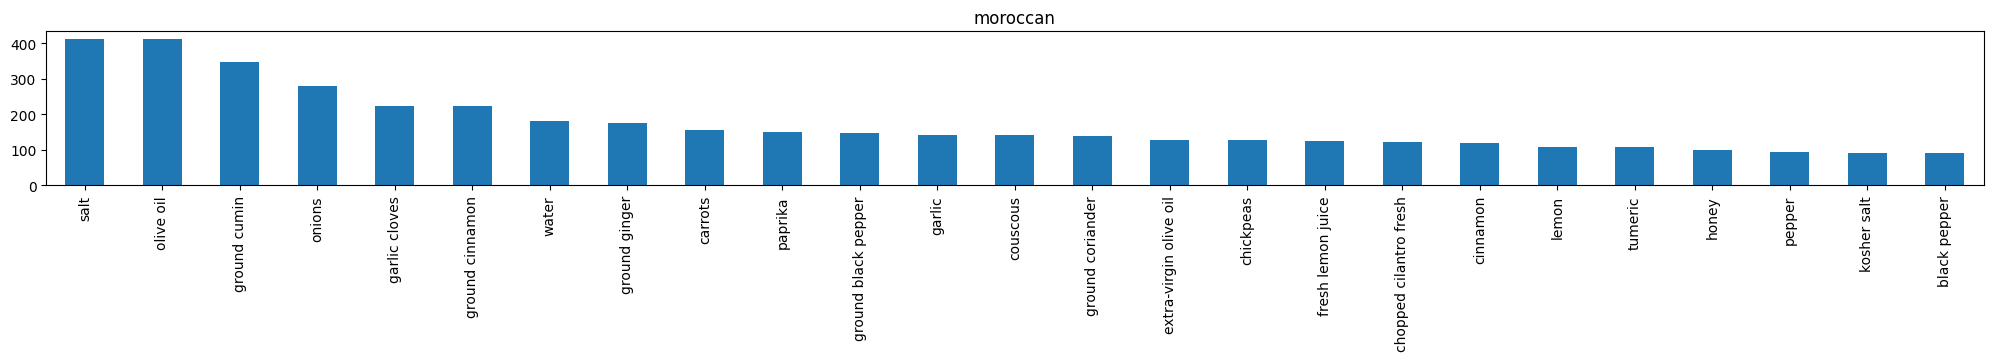

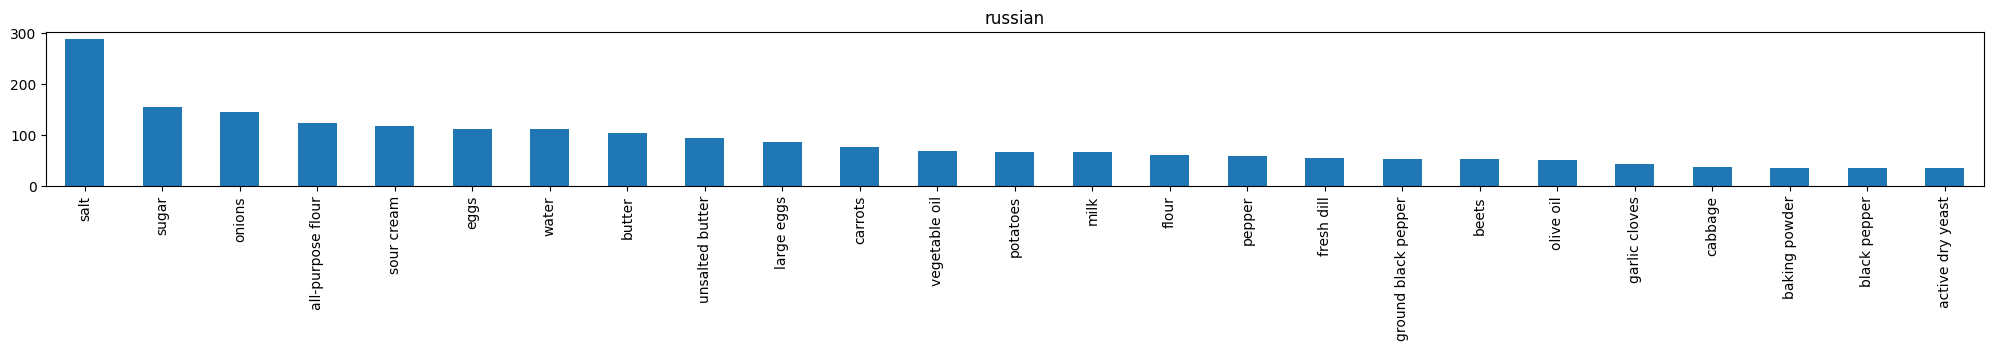

In [17]:
for key in all_cus.keys():
    fig, ax = plt.subplots(figsize=(25,2))
    pd.Series(all_cus[key]).value_counts().head(25).plot.bar(ax=ax, title=key)
    plt.show()

#### 25 Least used ingredients -- cuisine wise

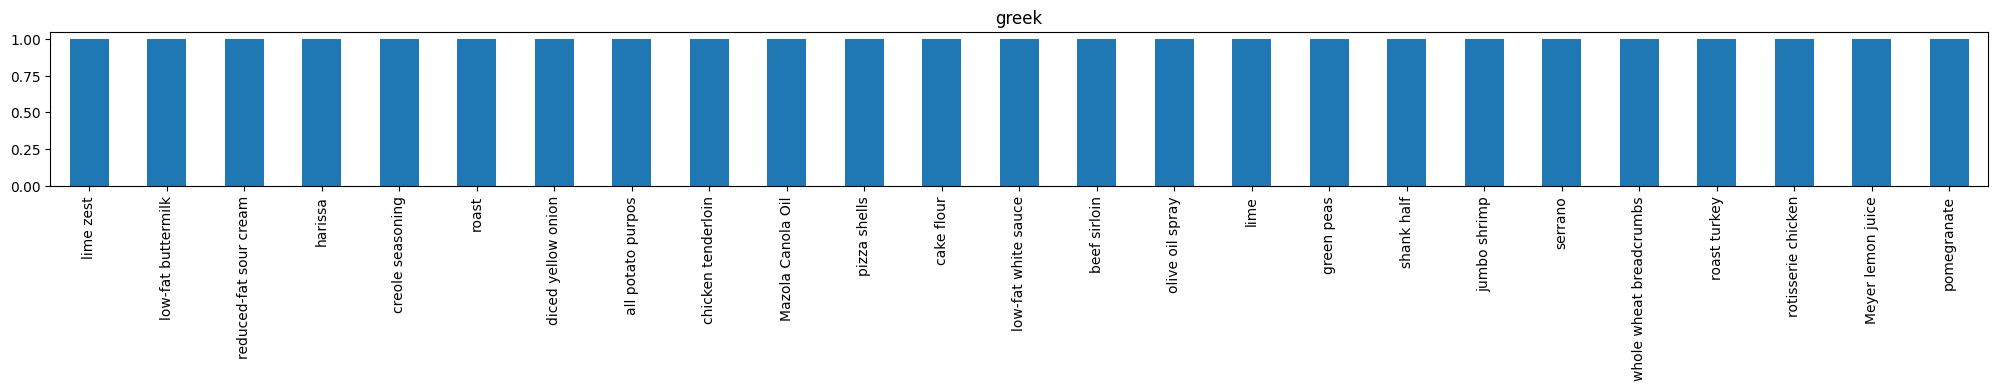

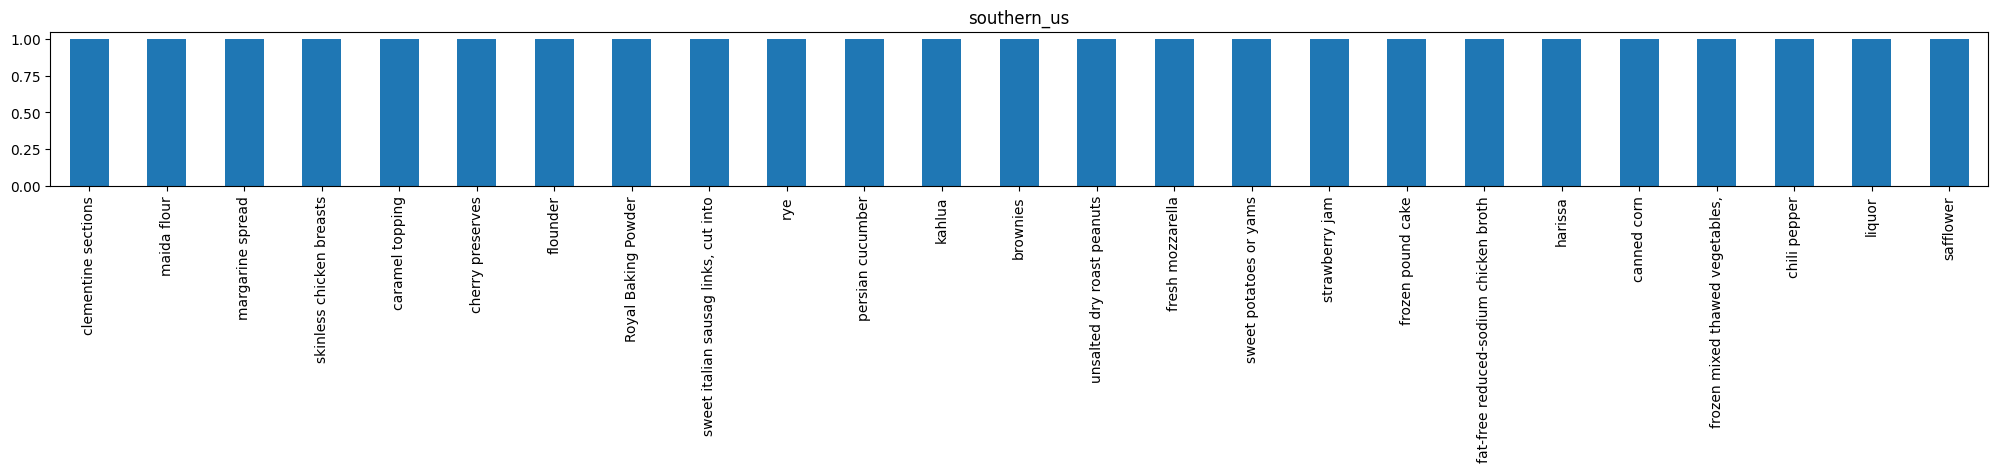

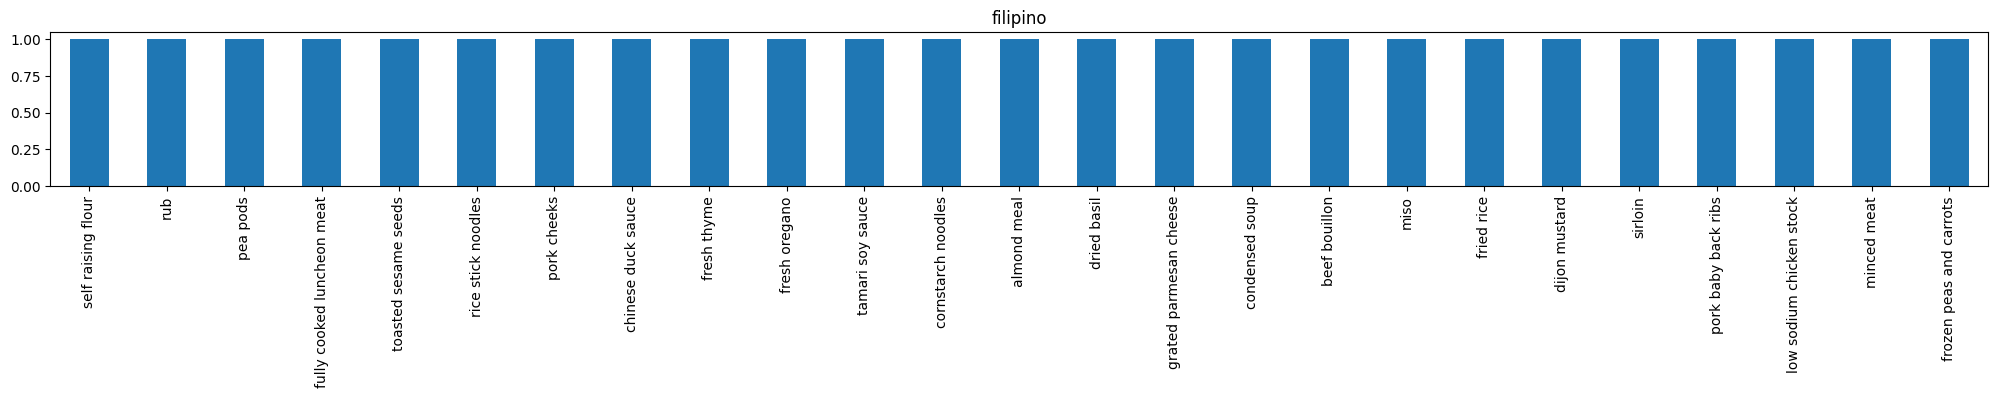

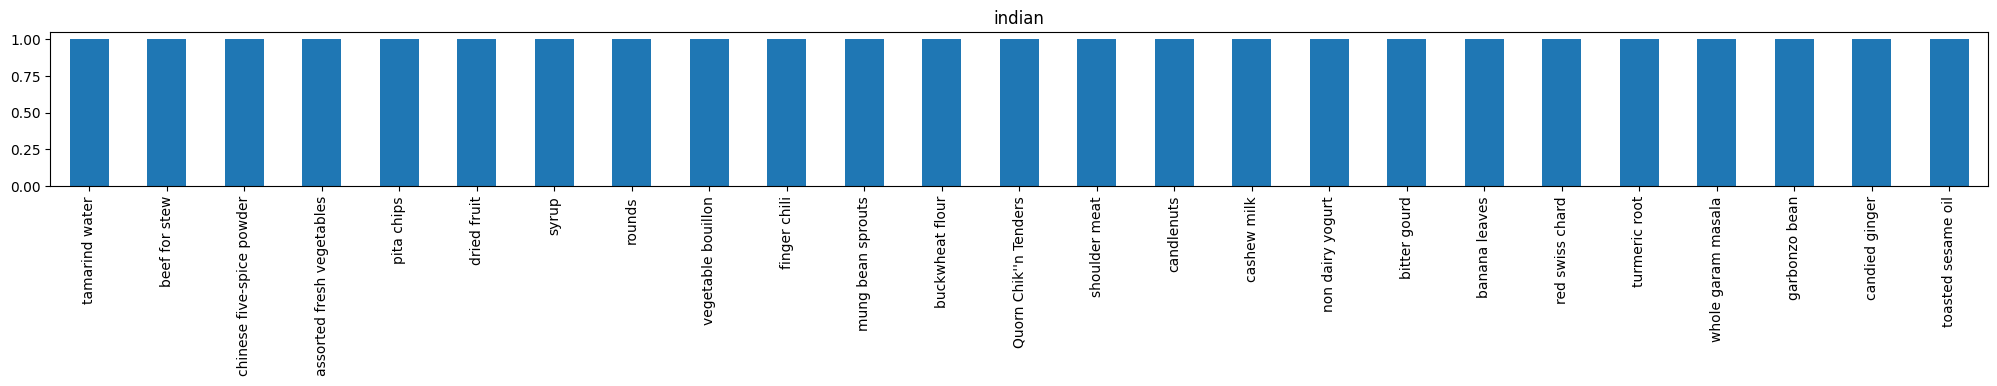

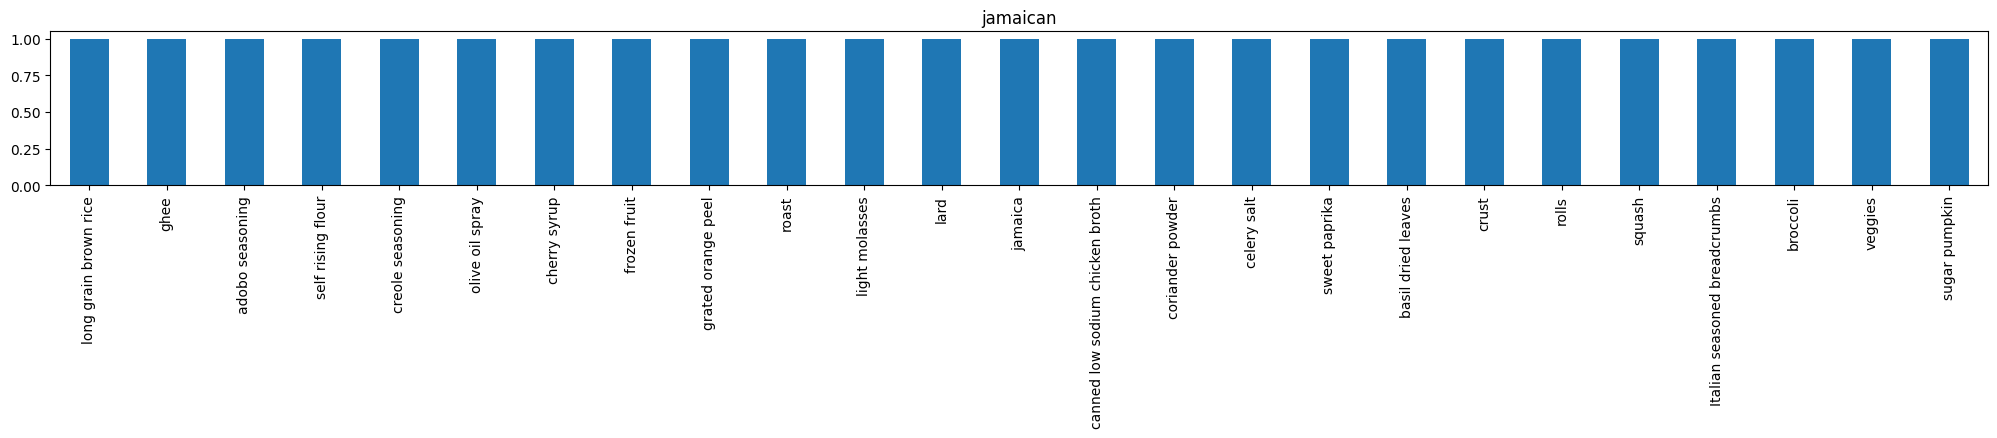

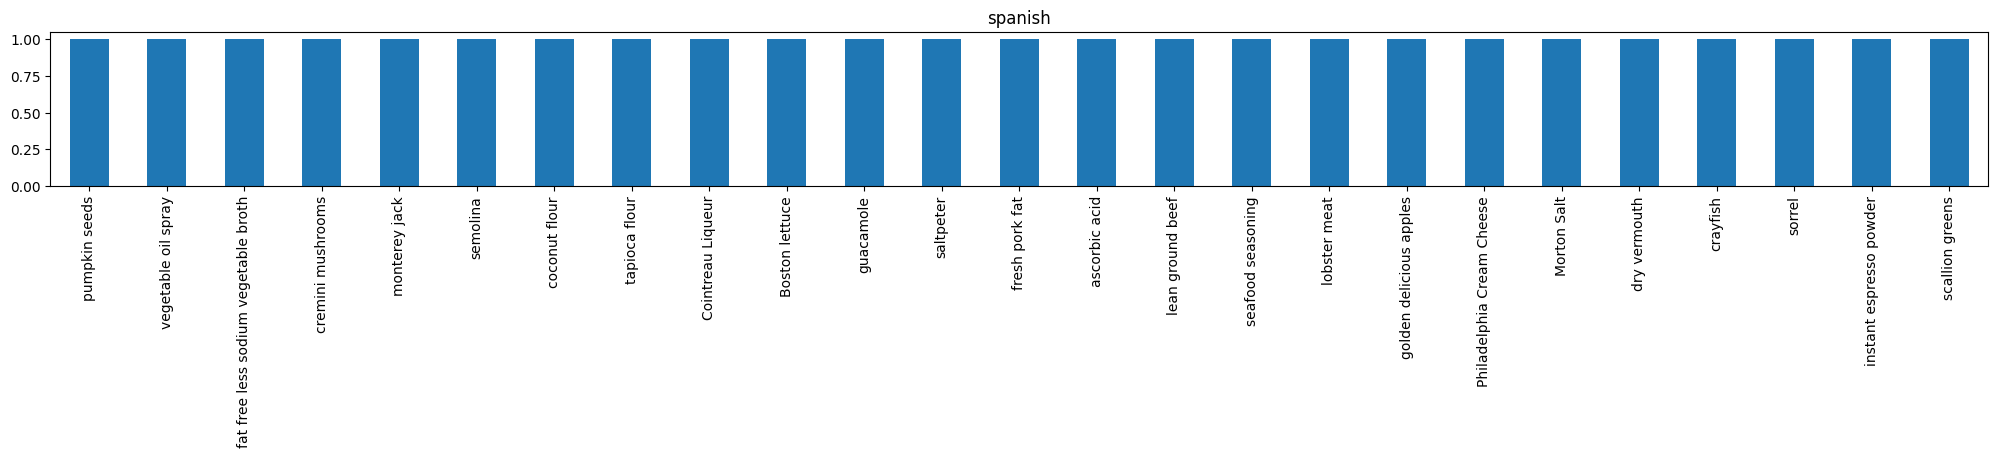

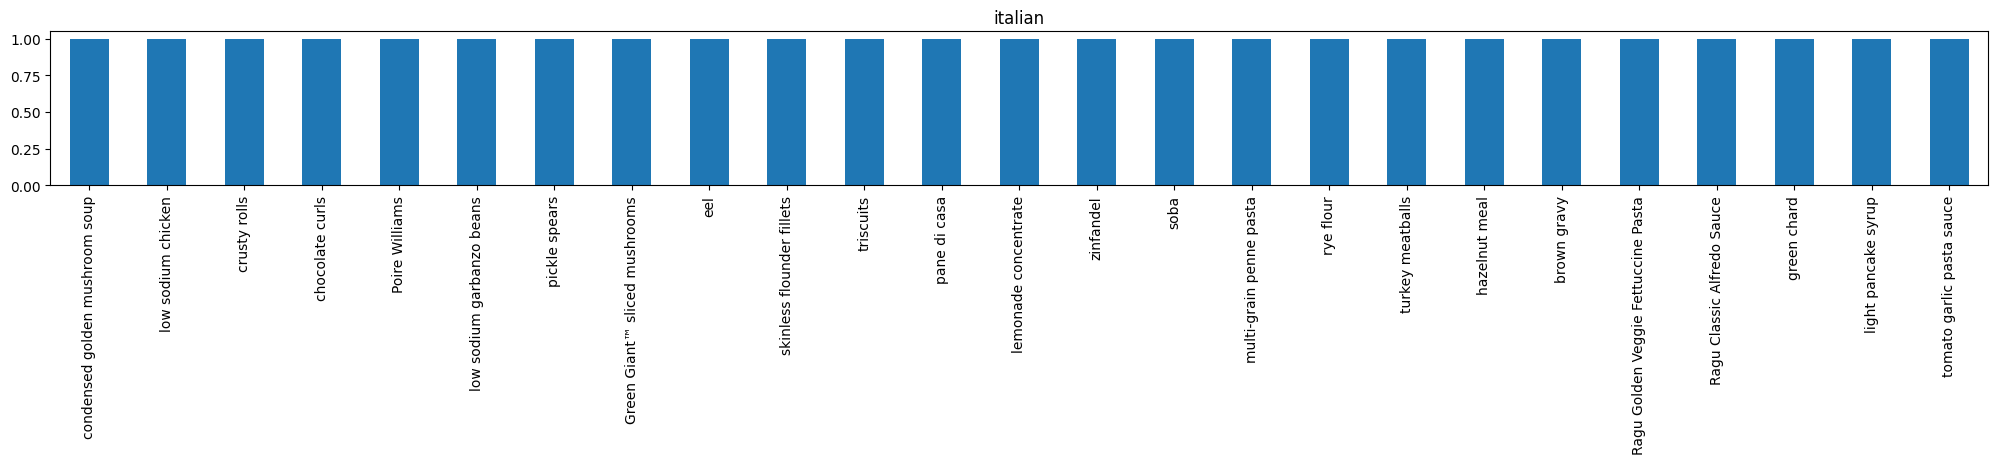

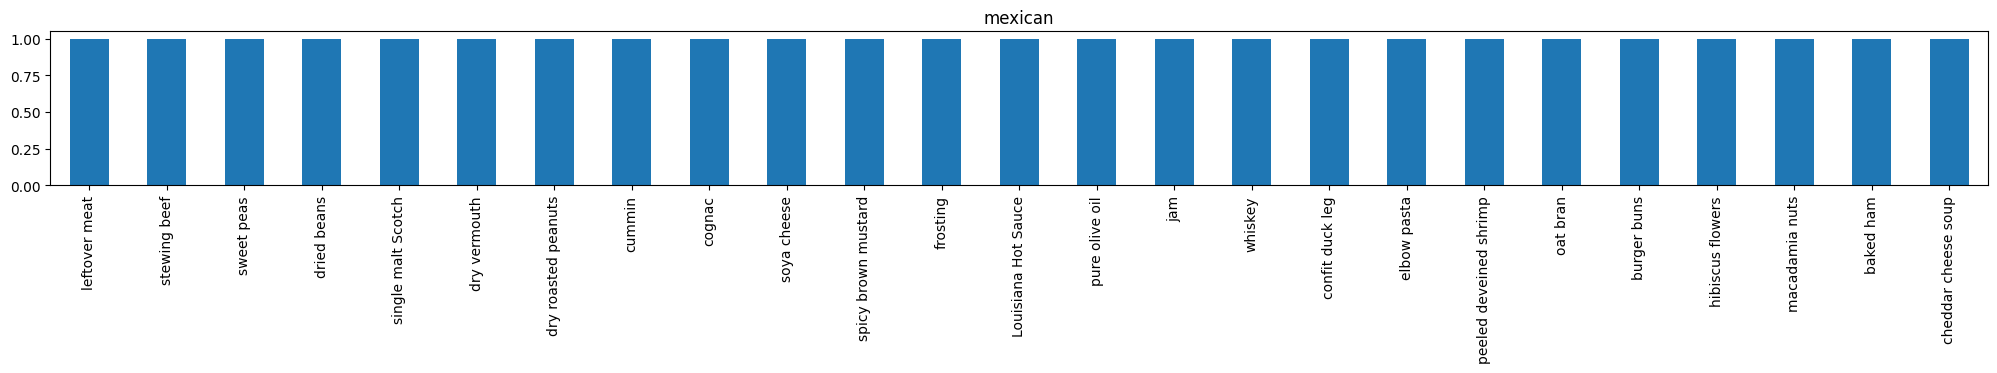

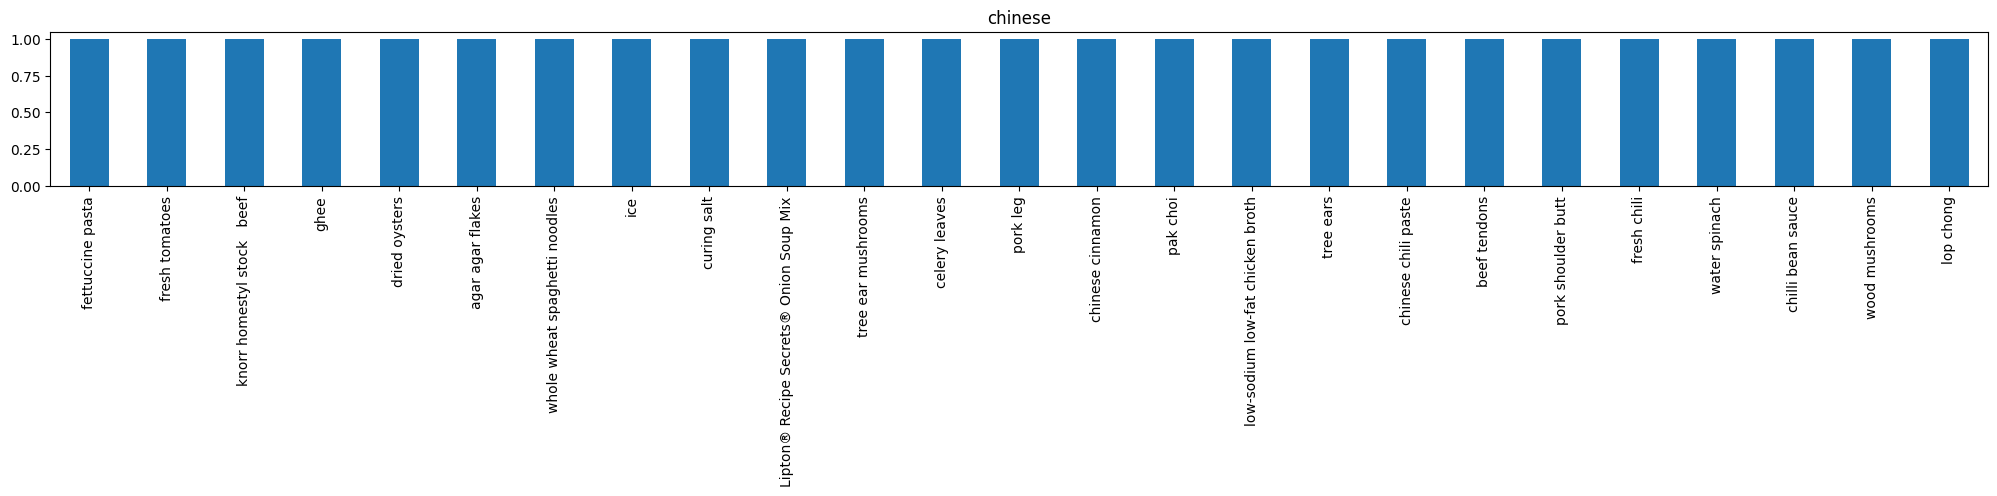

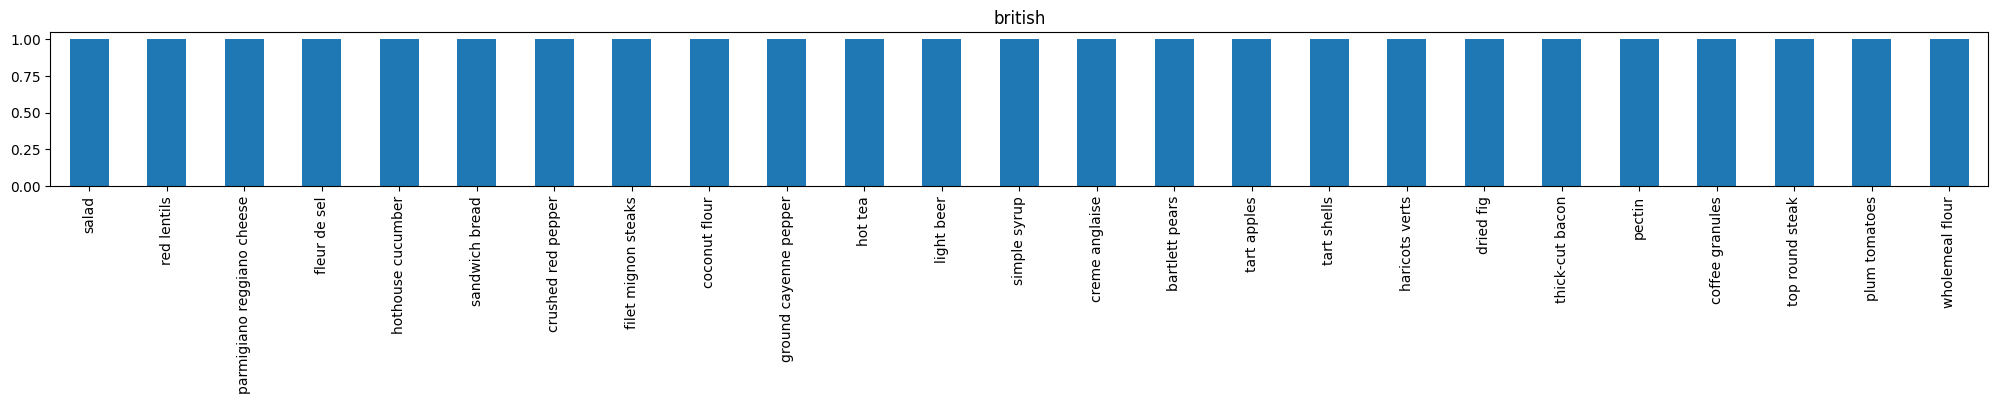

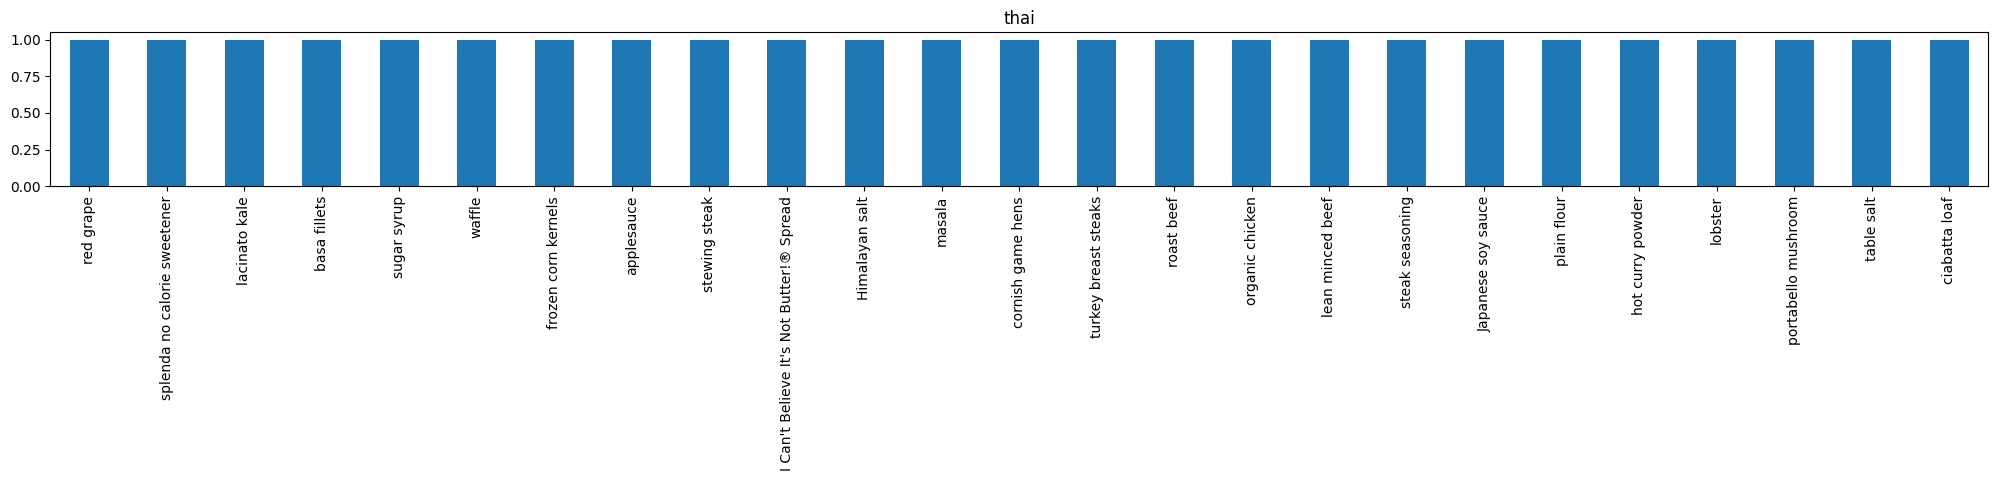

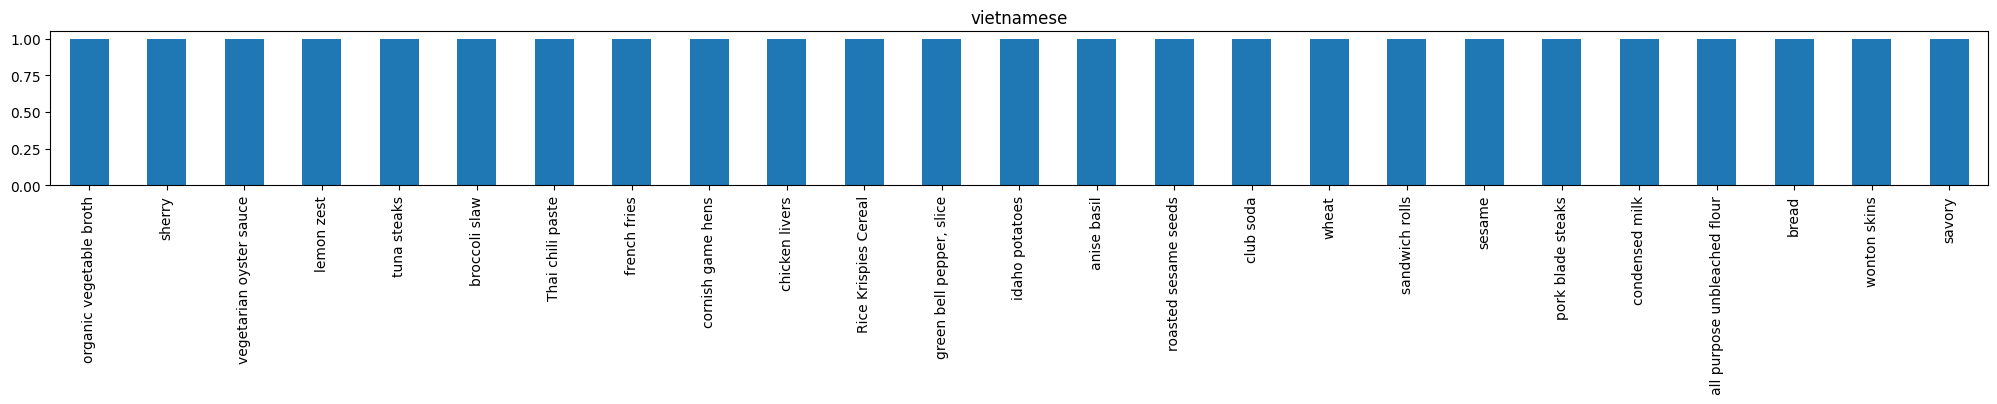

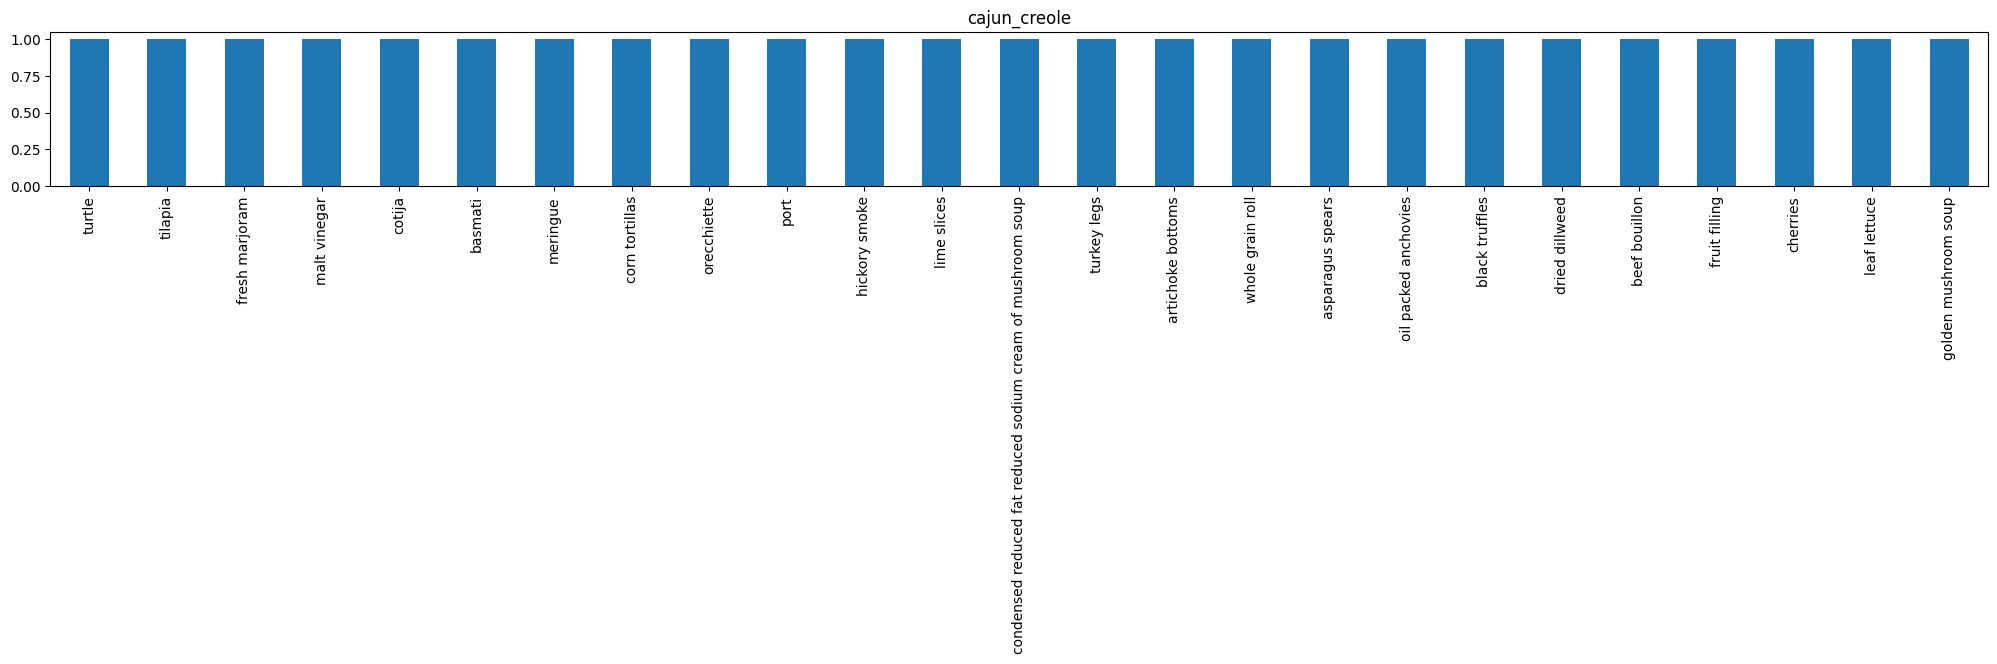

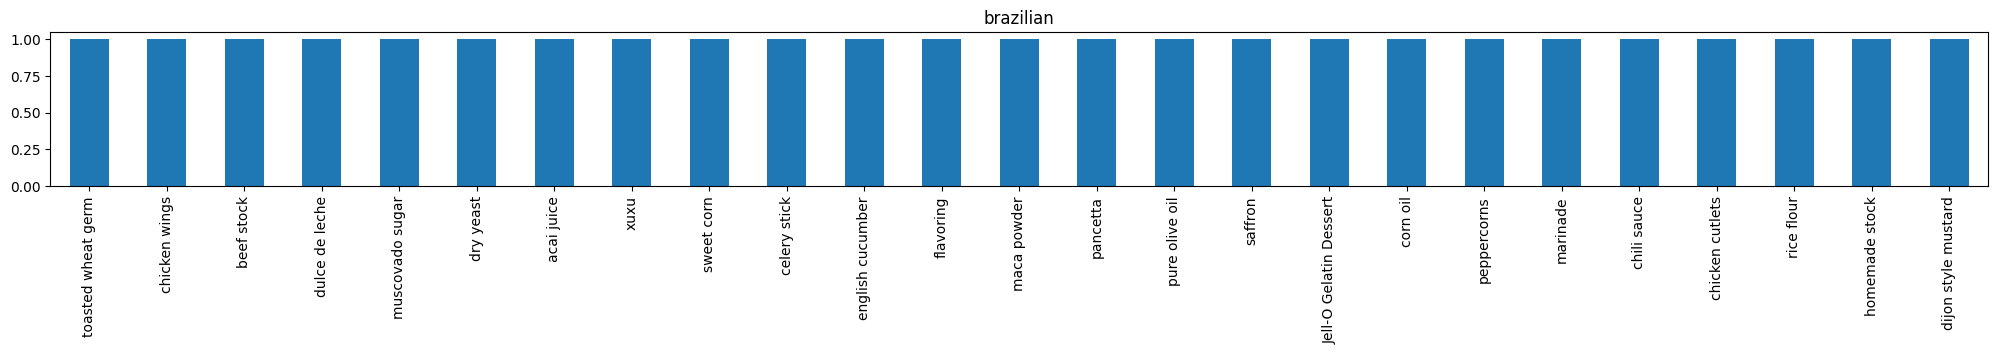

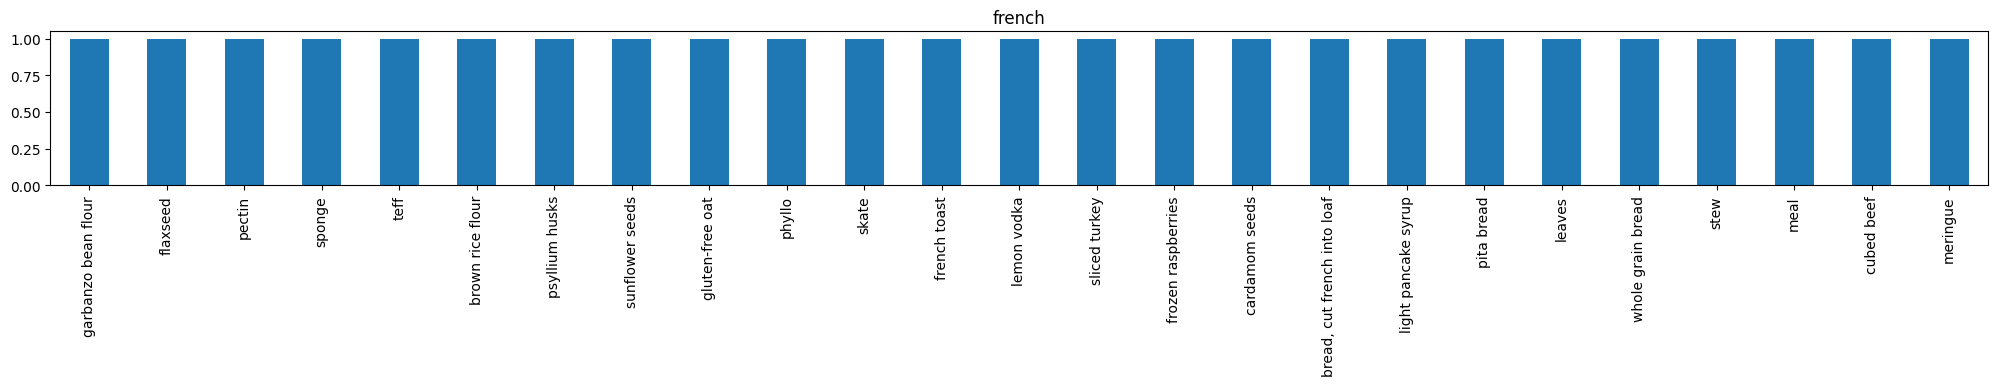

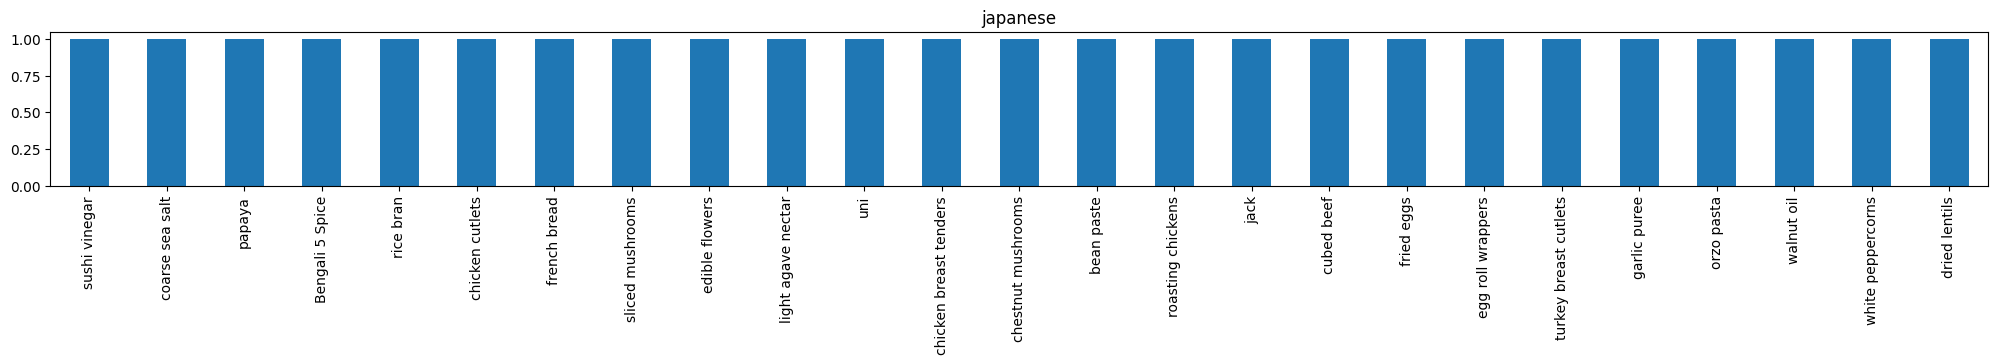

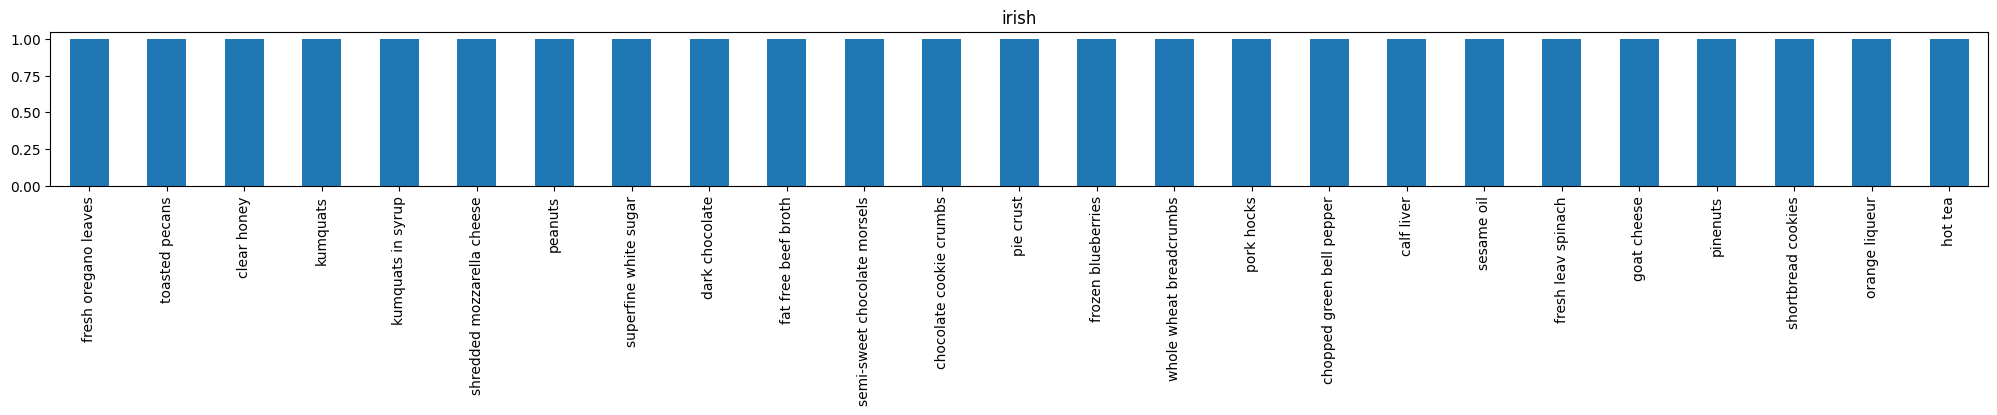

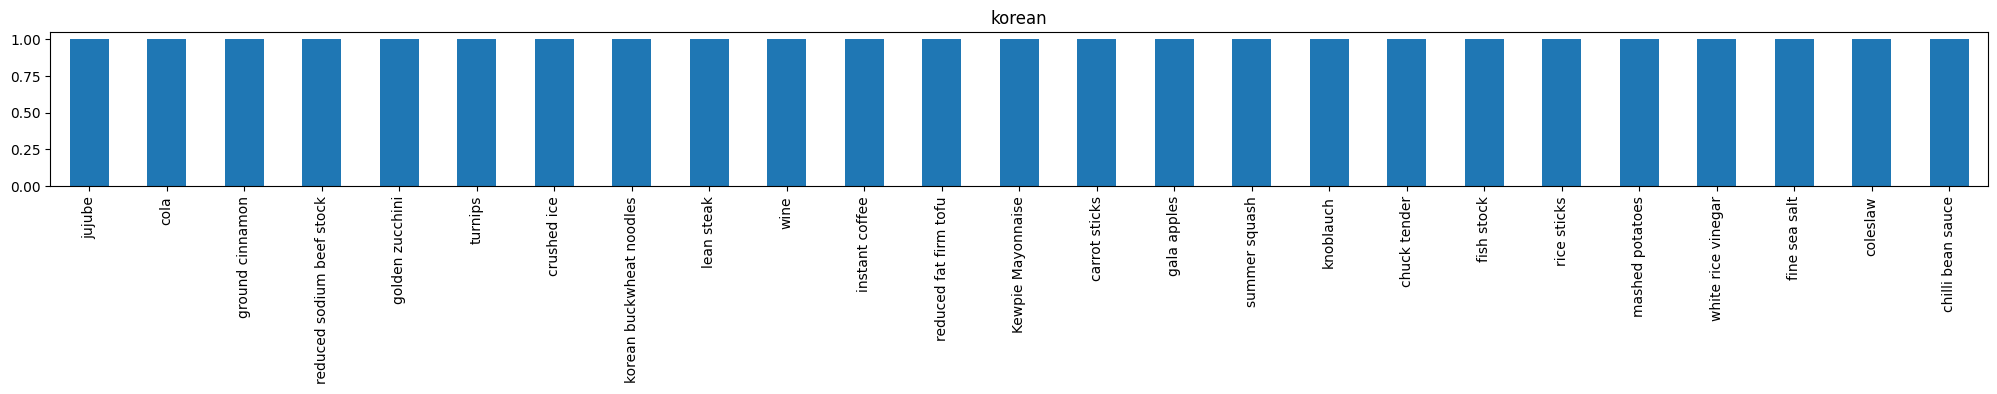

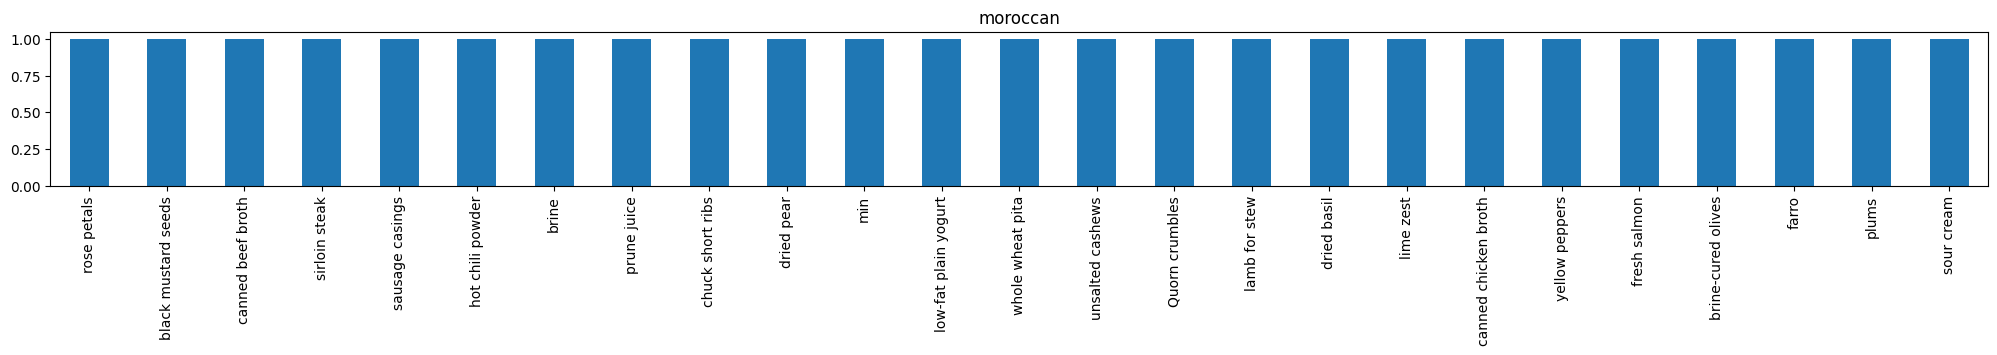

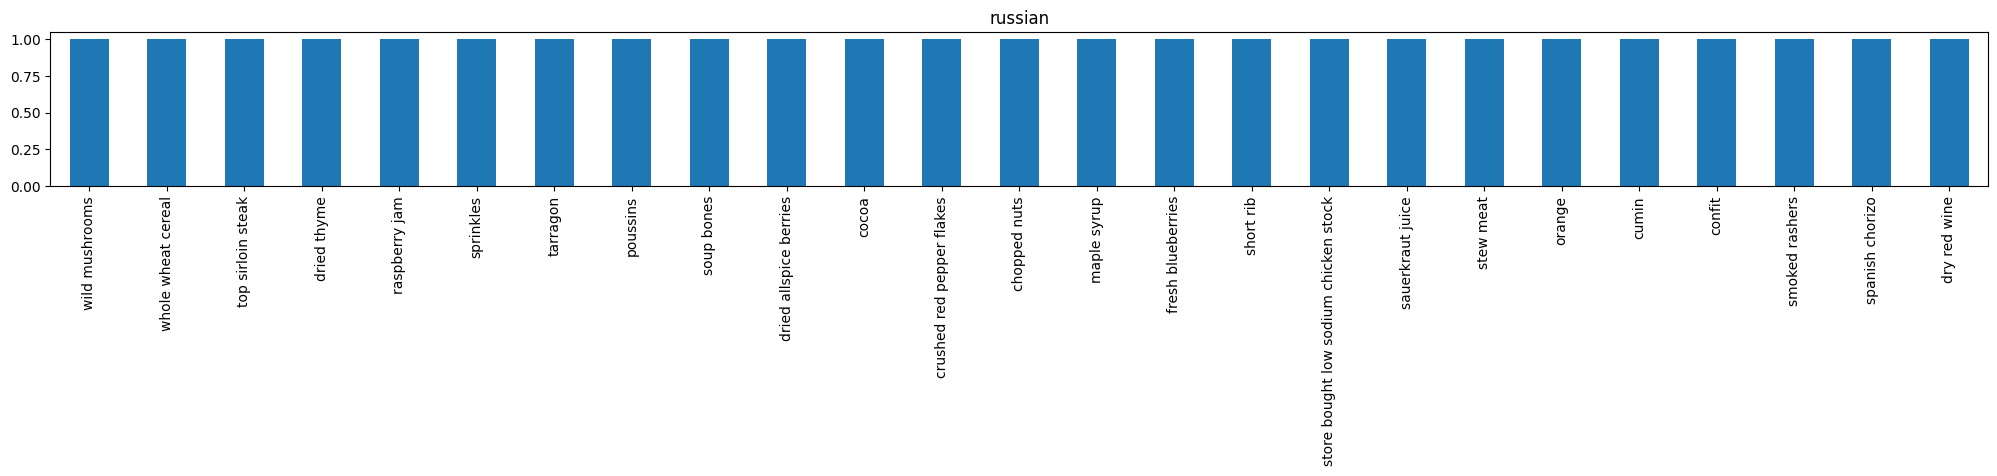

In [19]:
for key in all_cus.keys():
    fig, ax = plt.subplots(figsize=(25,2))
    pd.Series(all_cus[key]).value_counts().tail(25).plot.bar(ax=ax, title=key)
    plt.show()

### Preprocessing

* Lemmatization: For each string in the list `x`, it splits the string into words, lemmatizes each word using `WordNetLemmatizer` (from NLTK library), and joins the lemmatized words back into a single string. Lemmatization converts words to their base or dictionary form.
* Removing Specific Words: It uses `map` and a lambda function with a regular expression to remove specific words and phrases related to measurements and forms of ingredients, like "(...oz.)", "crushed", "crumbles", "ground", "minced", "powder", "chopped", and "sliced".
* Removing Non-alphabetic Characters: Another `map` and lambda function with a regular expression remove any character that is not a letter (a-z, A-Z), replacing them with a space.
* Joining Text: After cleaning, it joins the list of cleaned strings into a single string with spaces.
* Lowercasing: Converts the final string to lowercase.
* Dropping `id` Column: The function drops the `id` column from the DataFrame.
* Applying `process_string`: Applies the `process_string` function to each element of the 'ingredients' column in the DataFrame. This transforms the 'ingredients' column according to the rules defined in `process_string`.

In [20]:
def preprocess_df(df):
    
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', x), x))
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

In [21]:
def get_cuisine_cumulated_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])

    for cus in cuisine:
        st = ""
        for x in df[df.cuisine == cus]['ingredients']:
            st += x
            st += " "
        cuisine_df.loc[cus,'ingredients'] = st

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

In [22]:
df = preprocess_df(df)
test_df = preprocess_df(test_df)

cuisine_df = get_cuisine_cumulated_ingredients(df)

In [23]:
df.head()

,cuisine,ingredients
0,greek,romaine lettuce black olive grape tomato garli...
1,southern_us,plain flour pepper salt tomato black pepper ...
2,filipino,egg pepper salt mayonaise cooking oil green ch...
3,indian,water vegetable oil wheat salt
4,indian,black pepper shallot cornflour cayenne pepper ...


In [24]:
cuisine_df.head()

,cuisine,ingredients
0,greek,romaine lettuce black olive grape tomato garli...
1,southern_us,plain flour pepper salt tomato black pepper ...
2,filipino,egg pepper salt mayonaise cooking oil green ch...
3,indian,water vegetable oil wheat salt black pepper sh...
4,jamaican,plain flour sugar butter egg fresh ginger root...


In [25]:
train = df['ingredients']
target = df['cuisine']
test = test_df['ingredients']

### Count vectorizer

In [26]:
def count_vectorizer(train, test=None):
    cv = CountVectorizer()
    train = cv.fit_transform(train)
    if test is not None:
        test = cv.transform(test)
        return train, test, cv
    else:
        return train, cv

In [27]:
# train_cv , test_cv, cv = count_vectorizer(train,test)
# cuisine_data_cv, cuisine_cv = count_vectorizer(cuisine_df['ingredients'])

### TFiDF Vectorizer

In [28]:
def tfidf_vectorizer(train, test=None, save_vectorizer=False):
    tfidf = TfidfVectorizer(stop_words='english',
                            ngram_range = (1, 1),
                            analyzer="word", 
                            max_df = .57, 
                            binary=False, 
                            token_pattern=r'\w+', 
                            sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if save_vectorizer:
        with open('tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf, f)
    if test is not None:
        test = tfidf.transform(test)
        return train, test, tfidf
    else:
        return train, tfidf

In [29]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train, test, save_vectorizer=True)
cuisine_data_tfidf, cuisine_tfidf = tfidf_vectorizer(cuisine_df['ingredients'])

### Model development

In [30]:
from scipy import sparse

train = train_tfidf
test = test_tfidf

#### Linear SVC

In [31]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score

param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],  
              'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge']} 

grid = GridSearchCV(LinearSVC(dual=True, max_iter=1000), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')

In [32]:
%%time
grid.fit(train, target) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increas

CPU times: user 2.79 s, sys: 374 ms, total: 3.17 s
Wall time: 31.6 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(dual=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],
                         'loss': ['hinge', 'squared hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro', verbose=3)

[CV 2/5] END C=0.001, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END .....C=0.1, loss=hinge, penalty=l2;, score=0.752 total time=   1.0s
[CV 1/5] END C=10, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=10, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=10, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=10, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END C=10, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END ........C=50, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ........C=50, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ........C=50, loss=hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ......C=50, loss=hinge, penalty=l2;, score=0.772 total time=   4.3s
[CV 4/5] END .....C=50

In [25]:
grid.best_params_

{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}

In [26]:
grid.best_score_

0.7857646647354912

In [27]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC, SVC

def evalfn(C, gamma):
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf', class_weight='balanced')
    f = cross_val_score(s, train, target, cv=5, scoring='f1_micro')
    return f.max()

In [ ]:
#!pip install bayesian-optimization

In [28]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
new_opt = BayesianOptimization(evalfn, {'C': (0.1, 1000),  
              'gamma': (0.0001, 1)  })

In [ ]:
############################################
### OPTIMIZED PARAMETERS ARE SHOWN BELOW ###
##  HYPER PARAMETER OPT IS TIME CONSUMING ##
############################################

# %%time
# new_opt.maximize(n_iter=15, init_points=3)   


In [ ]:
# new_opt.max

In [29]:
# OPTIMIZED PARAMETERS
# {'target': 0.7945391461758937,
#  'params': {'C': 604.5300203551828, 'gamma': 0.9656489284085462}}

# With cluster(n=19) as a parameter:
# {'target': 0.7940917661847894,
#  'params': {'C': 509.674609734803, 'gamma': 0.724238238886398}}

C = 604.5300203551828
gamma = 0.9656489284085462

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf')

In [30]:
%%time
clf.fit(train, target)

CPU times: user 1min 32s, sys: 1.08 s, total: 1min 33s
Wall time: 1min 33s


SVC(C=604.5300203551828, gamma=0.9656489284085462)

In [31]:
import pickle
from datetime import datetime

now = datetime.now()
print("MODEL SAVED AT {}".format(now))
model_name = "SVC-whats-cooking-trial-final2-{}.pickle.dat".format(now)
pickle.dump(clf, open(model_name, "wb"))

MODEL SAVED AT 2024-05-14 11:28:17.561766


In [32]:
# clf = pickle.load(open("SVC-whats-cooking-trial-final2-{}.pickle.dat", "rb"))

In [33]:
y_pred = clf.predict(test)

In [34]:
y_pred

array(['irish', 'southern_us', 'italian', ..., 'italian', 'southern_us',
       'mexican'], dtype=object)

In [35]:
test

<9944x2793 sparse matrix of type '<class 'numpy.float64'>'
	with 172907 stored elements in Compressed Sparse Row format>

[CV 2/5] END ...C=0.001, loss=hinge, penalty=l2;, score=0.644 total time=   0.5s
[CV 2/5] END .......C=1, loss=hinge, penalty=l2;, score=0.791 total time=   1.1s
[CV 3/5] END ......C=50, loss=hinge, penalty=l2;, score=0.767 total time=   4.7s
[CV 4/5] END .....C=500, loss=hinge, penalty=l2;, score=0.741 total time=  14.0s
[CV 1/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=5000, loss=squared hinge, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END C=5000, loss=squared hinge, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END